In [1]:
from astropy.table import Table, QTable, join, vstack
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants

import numpy as np

import os

import matplotlib.pyplot as plt

In [2]:
c = constants.c.to('km/s')

h = 1
H0 = 100*h

# Read in list of observed PV targets from fuji

In [3]:
PV_observed = Table.read('/global/project/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')

In [4]:
PV_observed[:5]

<Table length=5>
    TARGETID        TARGET_RA     ...         RA                DEC        
     int64           float64      ...      float64            float64      
---------------- ---------------- ... ------------------ ------------------
1079550234591232 194.390863195343 ... 194.39086319534337  27.51572117901454
1092744374124544 194.390863195343 ... 194.39086319534337  27.51572117901454
1092744374124546 194.364461113654 ... 194.36446111365385  27.50371858813136
1092744369930240 194.338458724402 ... 194.33845872440244 27.491890269032595
1092744374124545 194.377858465028 ...  194.3778584650283 27.509810078028195

# Identify which of these targets are SGA galaxies

Only because I care about the Tully-Fisher relation and not the Fundamental Plane.  All Tully-Fisher objects are also SGA objects.

### Read in SGA catalog

In [5]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

In [6]:
SGA[:5]

<Table length=5>
SGA_ID  SGA_GALAXY          GALAXY         ... Z_COG_PARAMS_CHI2 ELLIPSEBIT
int64    bytes16           bytes29         ...      float32        int32   
------ ----------- ----------------------- ... ----------------- ----------
     2  SGA-2020 2              PGC1283207 ...       0.011723555          0
     3  SGA-2020 3              PGC1310416 ...        0.20391206          0
     4  SGA-2020 4 SDSSJ145059.93+135143.0 ...         1.8054093          0
     7  SGA-2020 7              PGC1742504 ...       0.004725194          0
    18 SGA-2020 18  2MASXJ12340801+4535444 ...       0.028653827          0

# Calculate the rotational velocity for each axis target

#### Calculate distance between the SGA galaxy's center and each observation

In [7]:
PV_observed['SKY_FIBER_DIST'] = 0.
PV_observed['SKY_FIBER_DIST_R26'] = 0.

# Identify all observations that are on galaxy centers
centers_idx = (PV_observed['TARGETID'] > 30000000000000000) & (PV_observed['TARGETID'] < 40000000000000000)

# For each SGA galaxy that has at least one observation, calculate the distance
# for all of that galaxy's targets
for sga_gal in np.unique(PV_observed['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = PV_observed['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA['SGA_ID'] == sga_gal
    
    # Calculate distance between each observation and the center
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=PV_observed['RA'][obs_idx], 
                             dec=PV_observed['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    PV_observed['SKY_FIBER_DIST'][obs_idx] = sep2d
    PV_observed['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx][0]*u.arcmin)

PV_observed[:5]

<Table length=5>
    TARGETID        TARGET_RA     ...    SKY_FIBER_DIST     SKY_FIBER_DIST_R26
     int64           float64      ...       float64              float64      
---------------- ---------------- ... -------------------- -------------------
1079550234591232 194.390863195343 ...  0.03927420444753712  1.0000000170652443
1092744374124544 194.390863195343 ...  0.03927420444753712  1.0000000170652443
1092744374124546 194.364461113654 ... 0.012960487467698754  0.3300000056318236
1092744369930240 194.338458724402 ... 0.012960487467685656 0.33000000563149007
1092744374124545 194.377858465028 ... 0.026313716979861984  0.6700000114340222

#### Calculate rotational velocities

In [8]:
PV_observed['V_ROT'] = np.nan
PV_observed['V_ROT_ERR'] = np.nan

# Identify all observations that are on galaxy centers
centers_idx = (PV_observed['TARGETID'] > 30000000000000000) & (PV_observed['TARGETID'] < 40000000000000000)

# Filter for "good" Redrock redshifts
goodz_idx = (PV_observed['ZWARN'] == 0) & (PV_observed['DELTACHI2'] > 25)

for sga_gal in np.unique(PV_observed['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = PV_observed['SGA_ID'] == sga_gal
    
    # Identify "good" center observation(s) of this galaxy
    center_idx = np.logical_and.reduce([centers_idx, obs_idx, goodz_idx])
    
    # Is there at least one "good" observation of the center?
    if np.sum(center_idx) > 0:
        
        # Use the average redshift of all center observations for the systemic velocity
        z_center = np.mean(PV_observed['Z'][center_idx])
        z_err_center2 = np.mean(PV_observed['ZERR'][center_idx]**2)/np.sum(center_idx)
        
        # Calculate rotational velocity for all observations of the galaxy
        PV_observed['V_ROT'][obs_idx] = c*(PV_observed['Z'][obs_idx] - z_center)
        PV_observed['V_ROT_ERR'][obs_idx] = c*np.sqrt(PV_observed['ZERR'][obs_idx]**2 + z_err_center2)

In [9]:
PV_observed[:5]

<Table length=5>
    TARGETID        TARGET_RA        TARGET_DEC    ...  V_ROT  V_ROT_ERR
     int64           float64          float64      ... float64  float64 
---------------- ---------------- ---------------- ... ------- ---------
1079550234591232 194.390863195343 27.5157211790145 ...     nan       nan
1092744374124544 194.390863195343 27.5157211790145 ...     nan       nan
1092744374124546 194.364461113654 27.5037185881314 ...     nan       nan
1092744369930240 194.338458724402 27.4918902690326 ...     nan       nan
1092744374124545 194.377858465028 27.5098100780282 ...     nan       nan

## For any of the large SGA galaxies, plot the rotation curve

#### Only plot those curves with multiple good velocity values

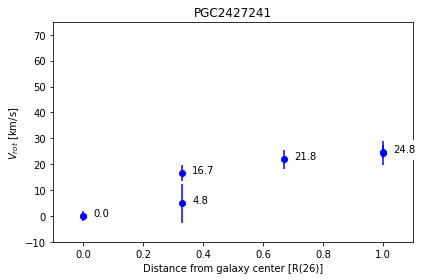

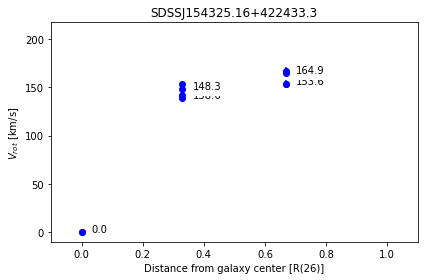

/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3417: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


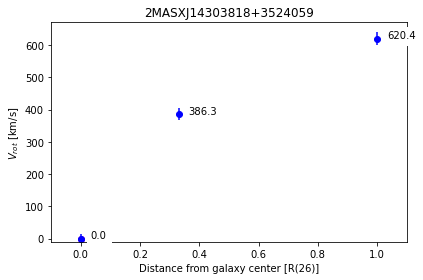

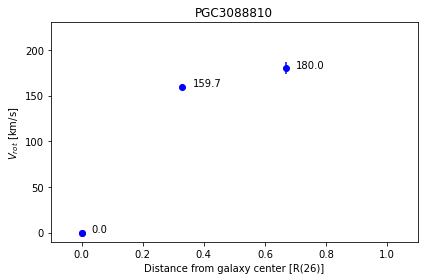

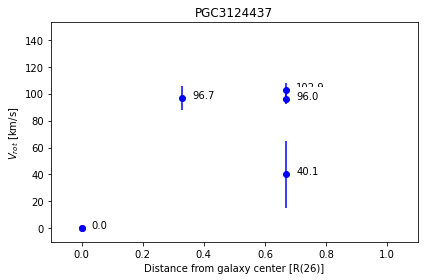

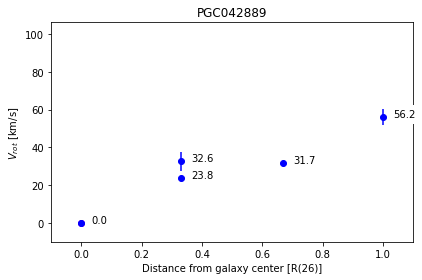

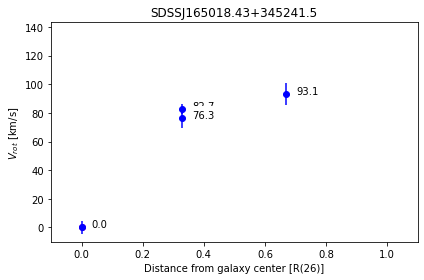

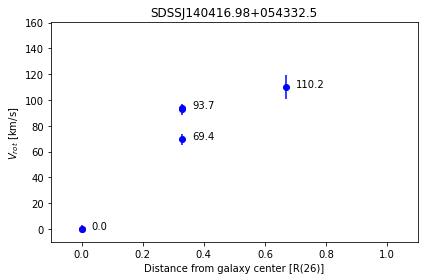

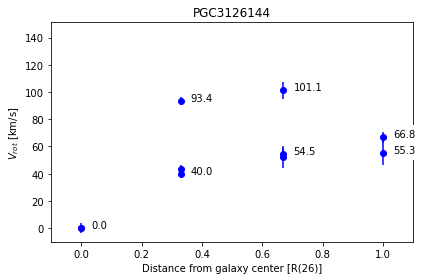

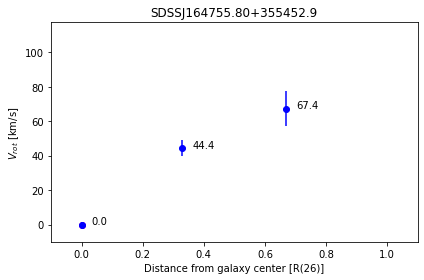

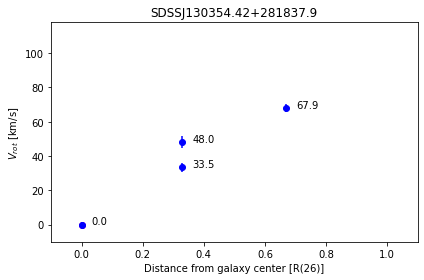

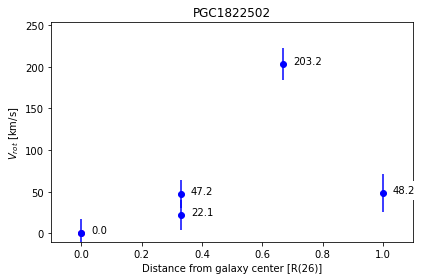

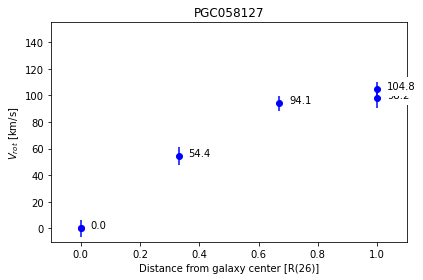

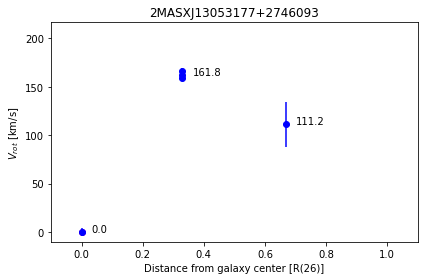

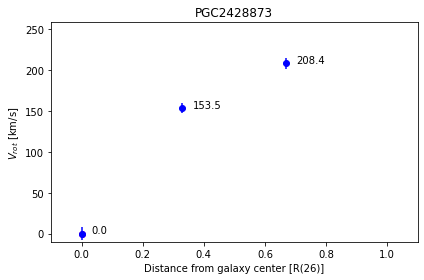

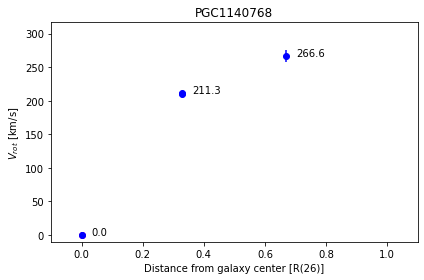

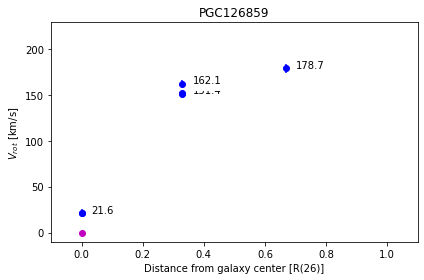

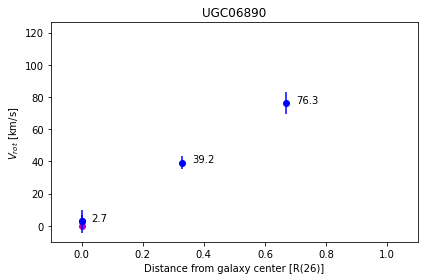

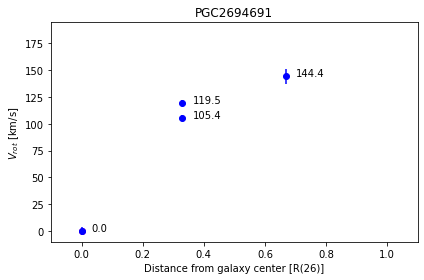

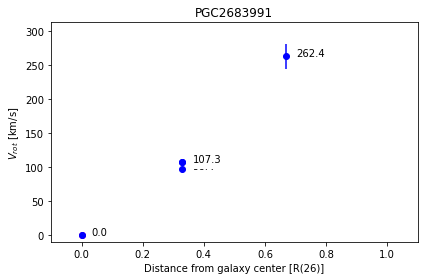

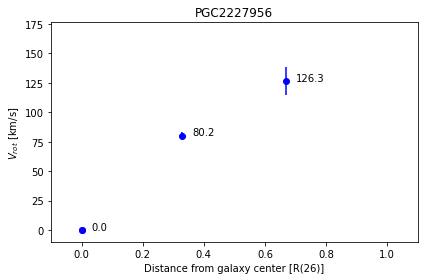

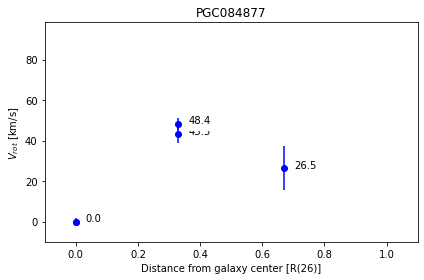

/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3417: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


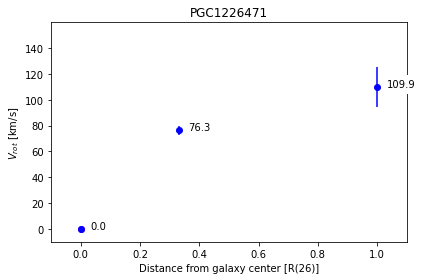

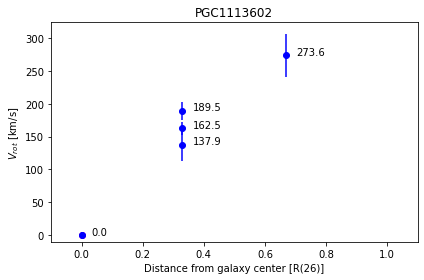

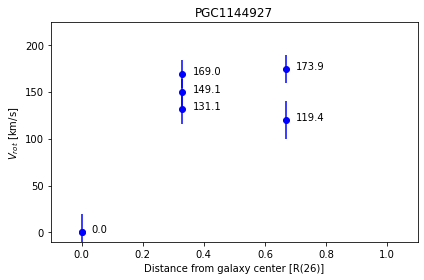

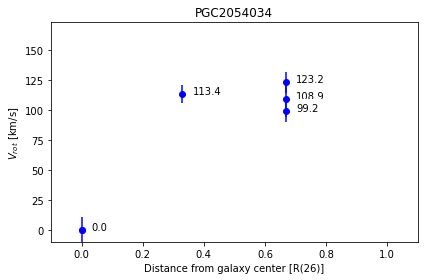

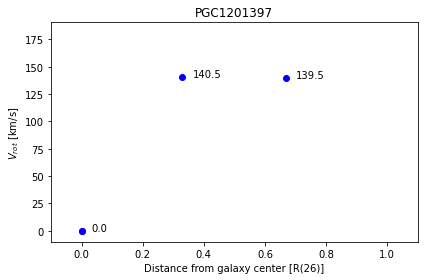

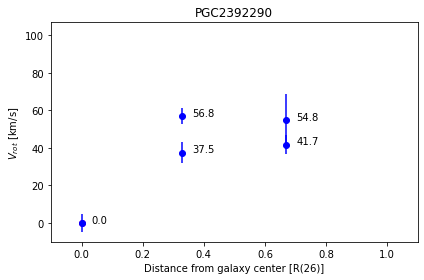

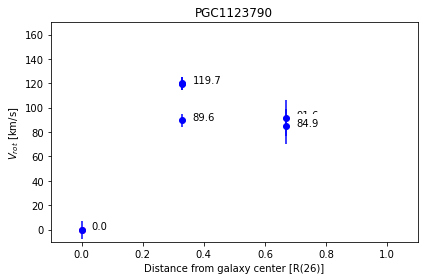

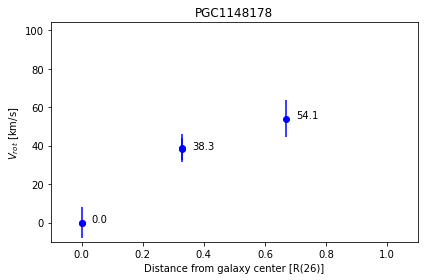

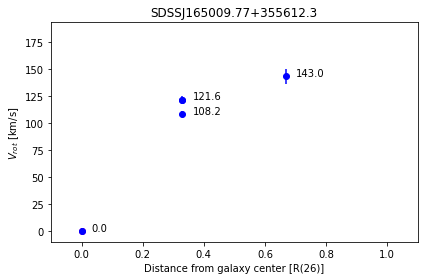

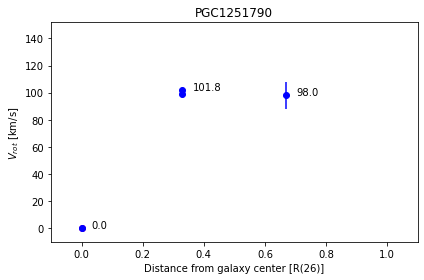

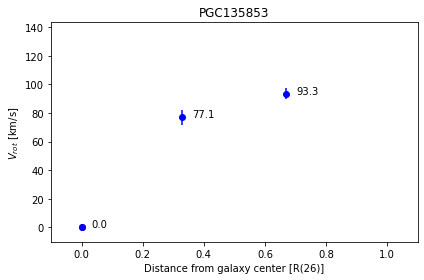

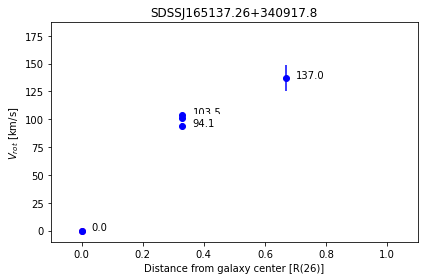

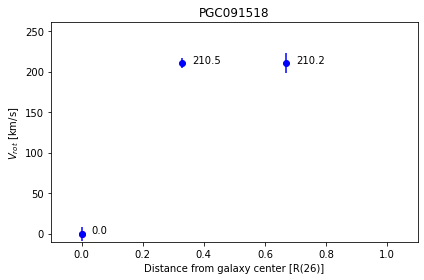

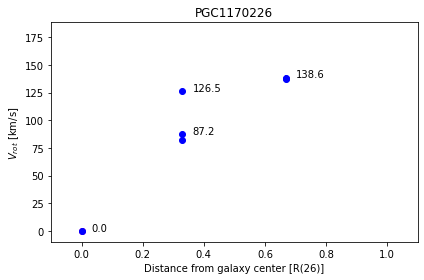

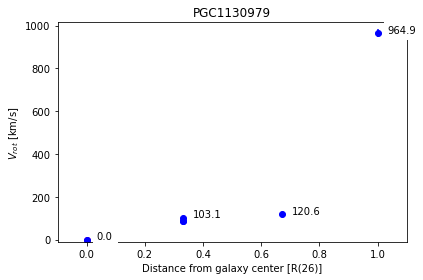

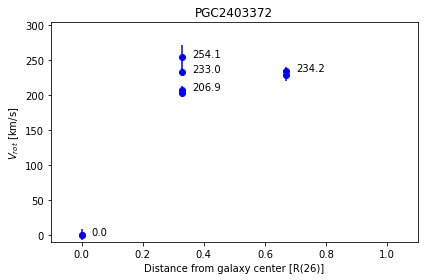

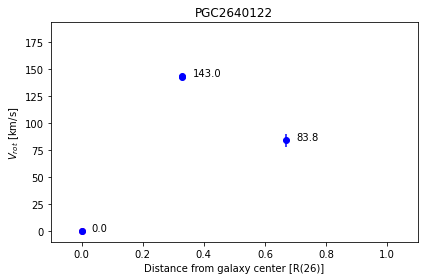

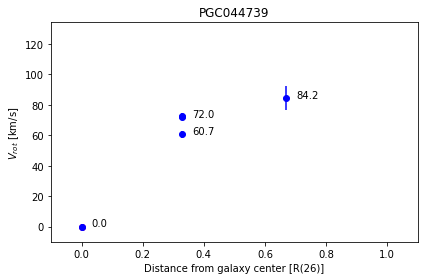

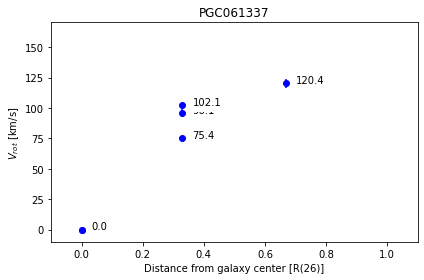

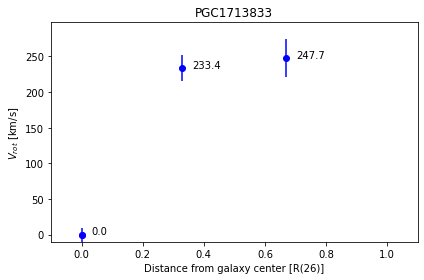

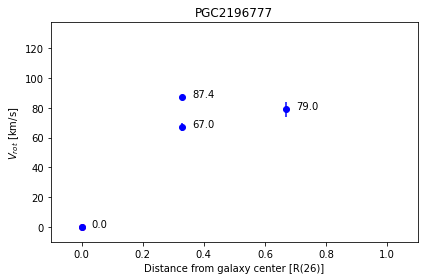

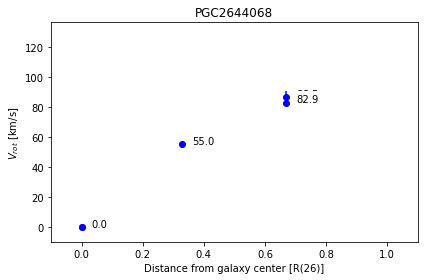

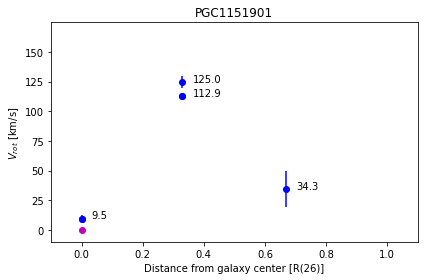

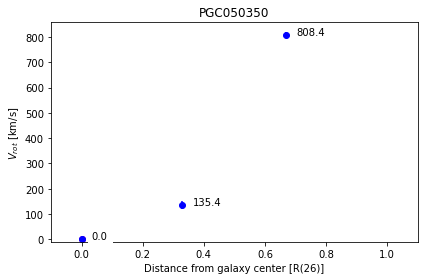

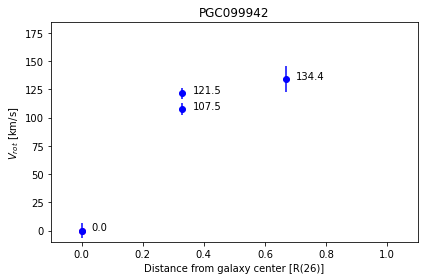

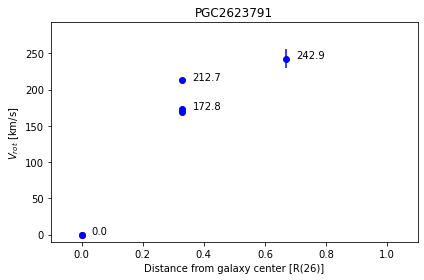

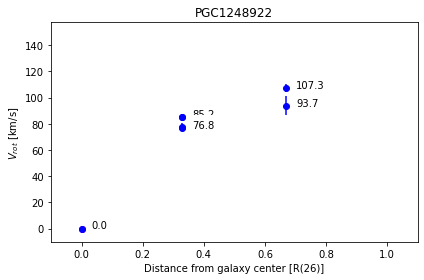

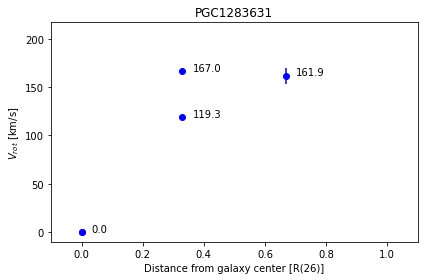

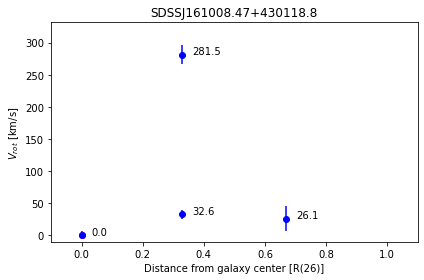

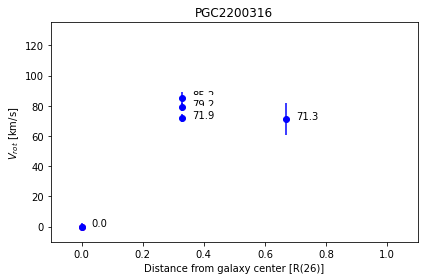

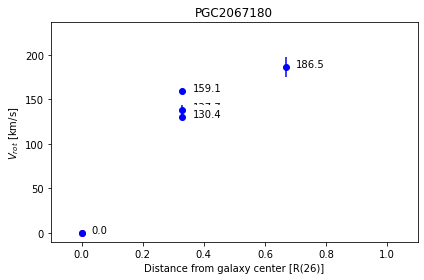

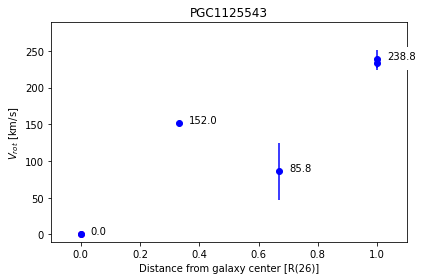

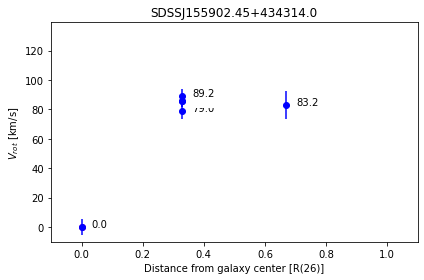

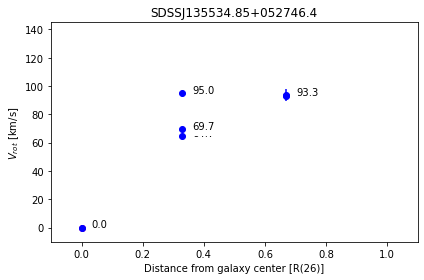

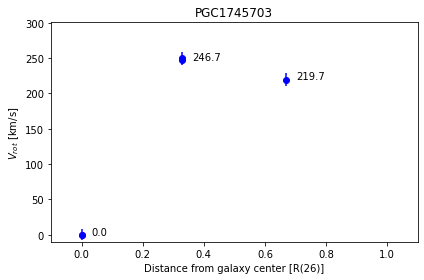

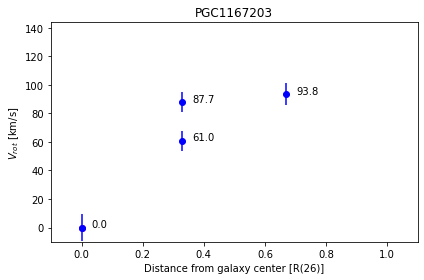

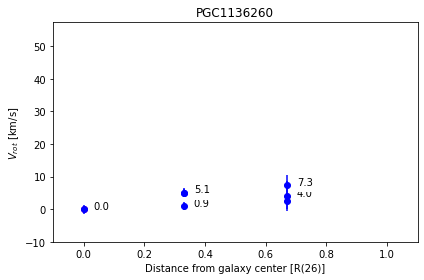

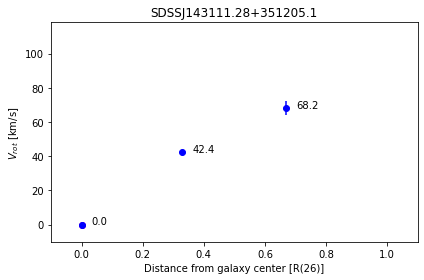

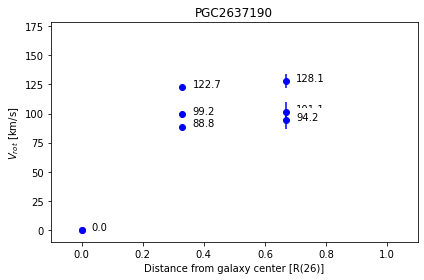

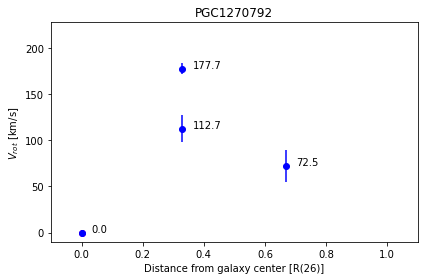

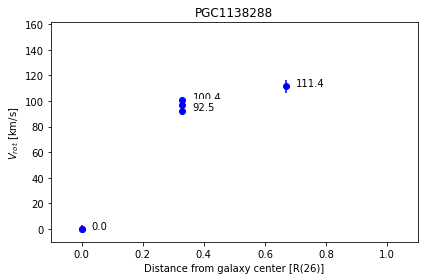

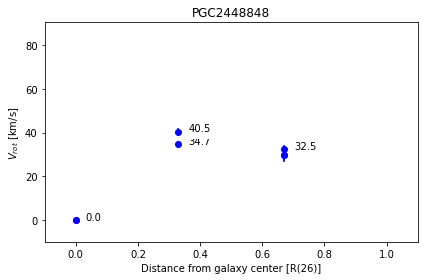

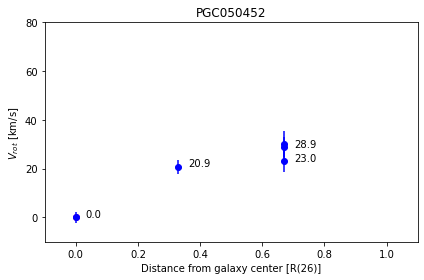

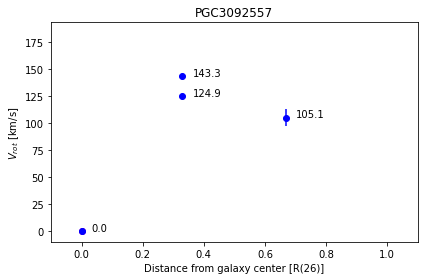

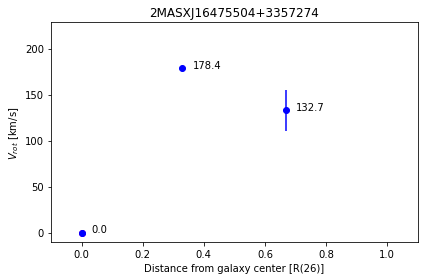

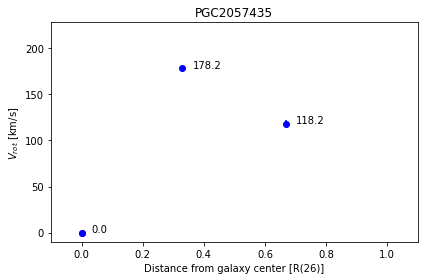

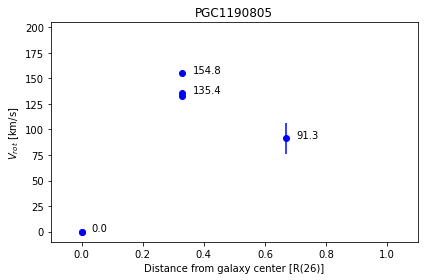

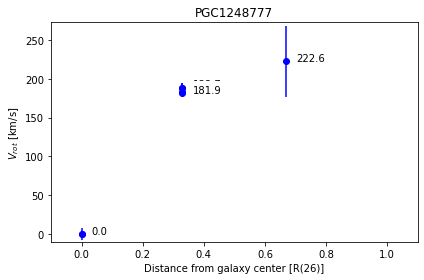

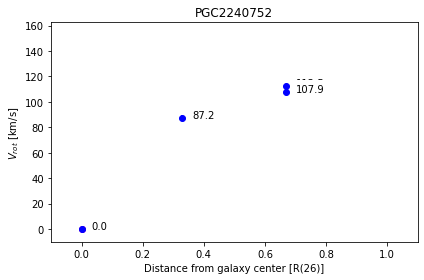

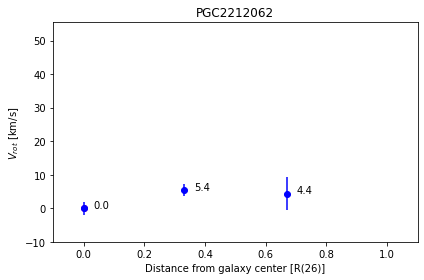

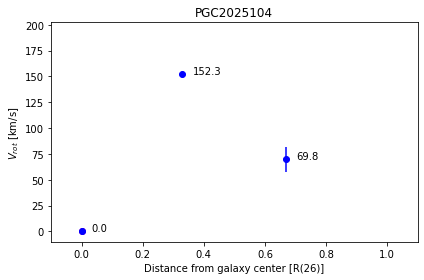

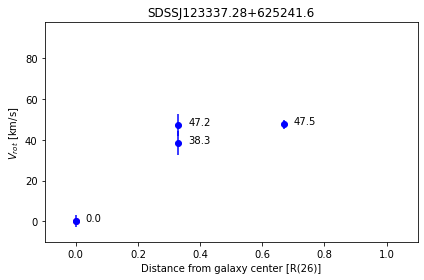

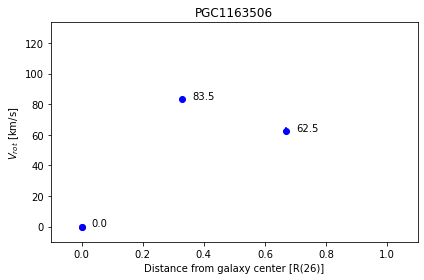

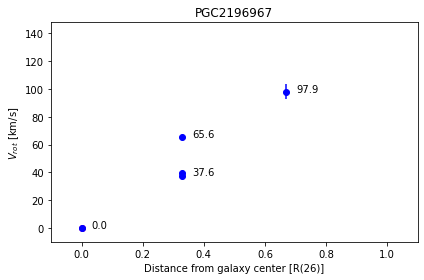

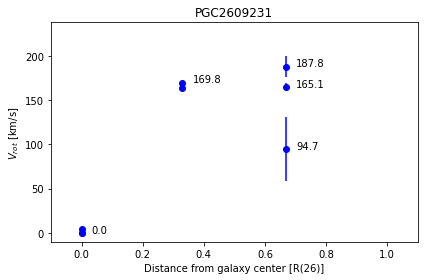

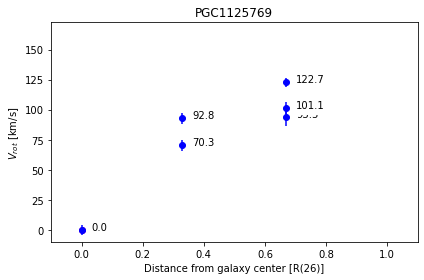

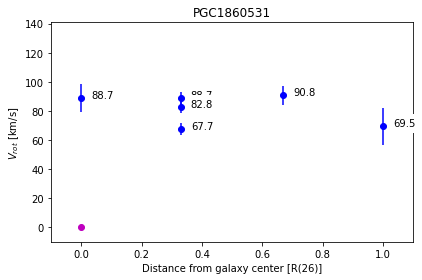

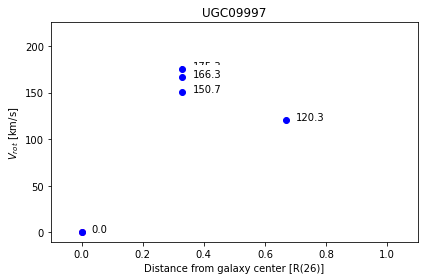

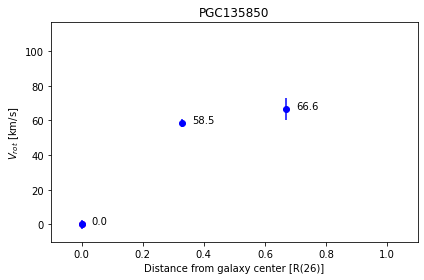

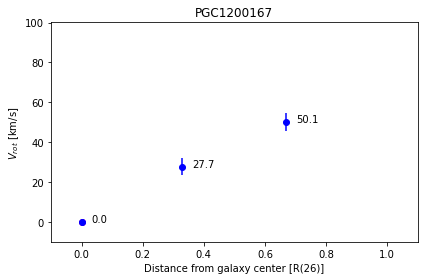

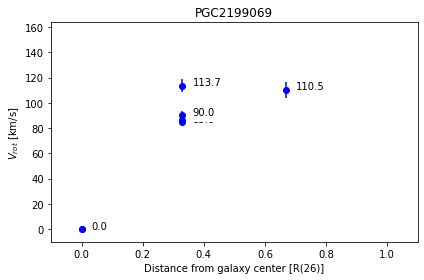

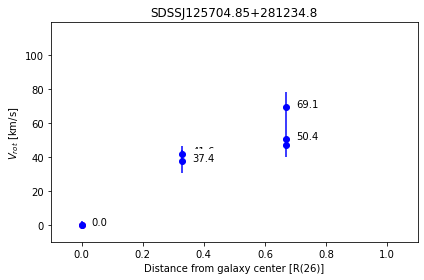

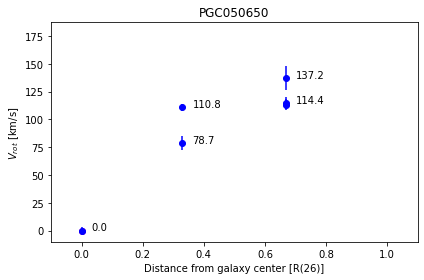

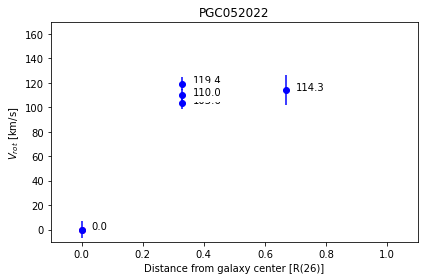

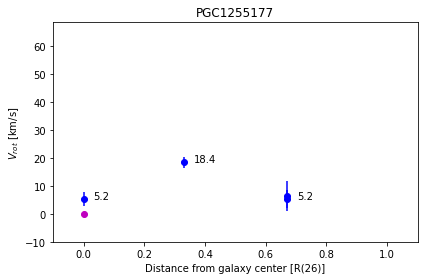

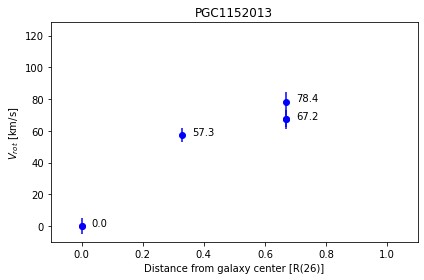

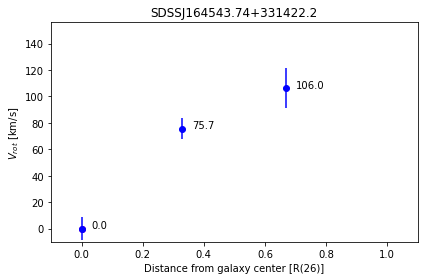

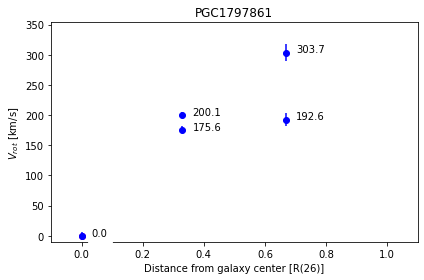

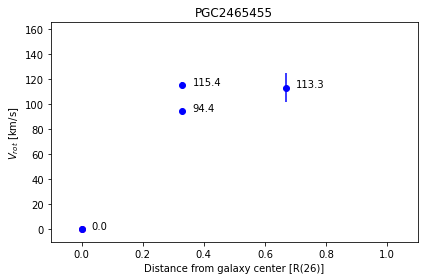

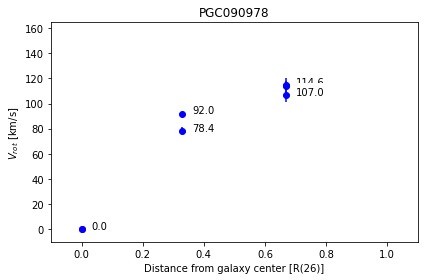

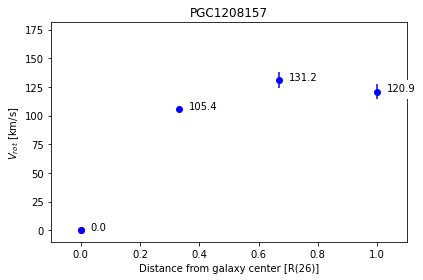

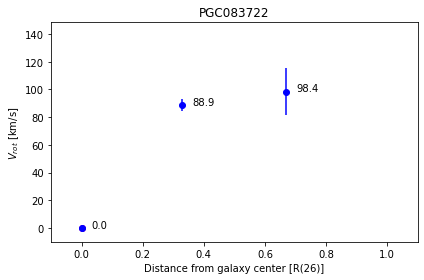

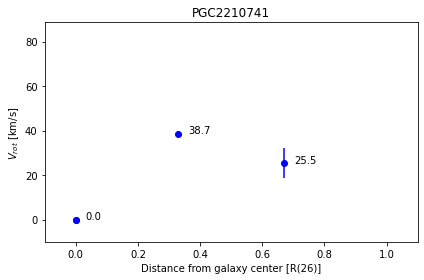

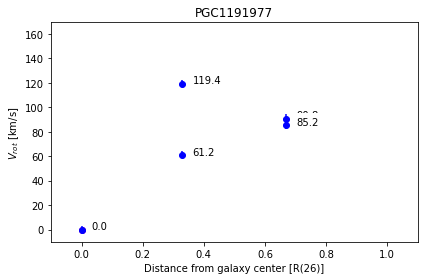

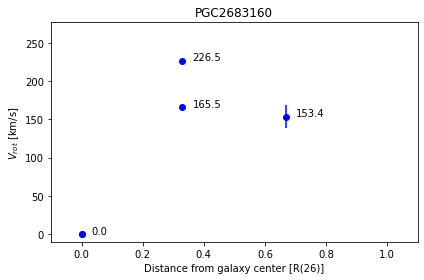

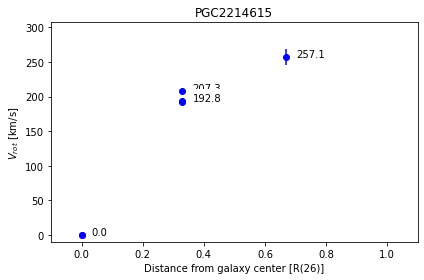

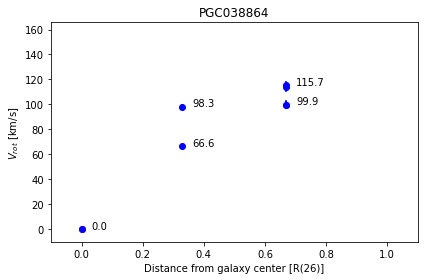

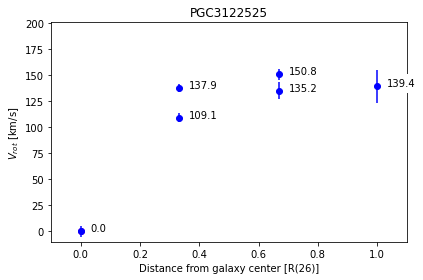

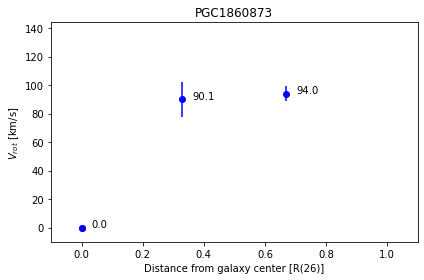

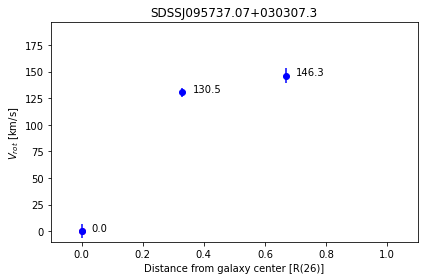

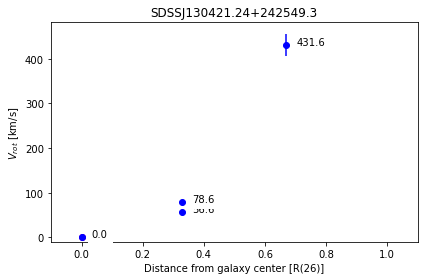

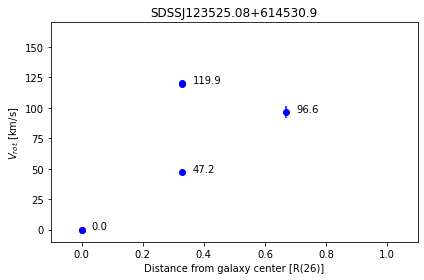

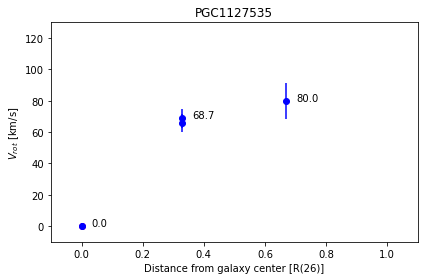

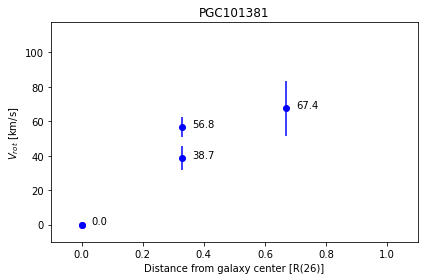

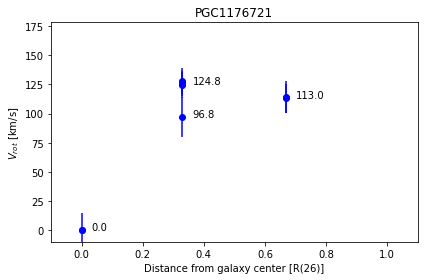

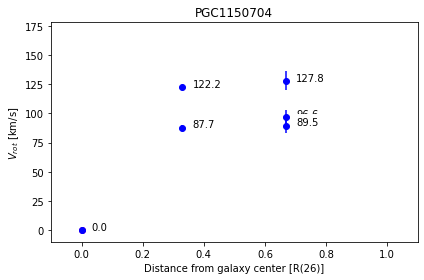

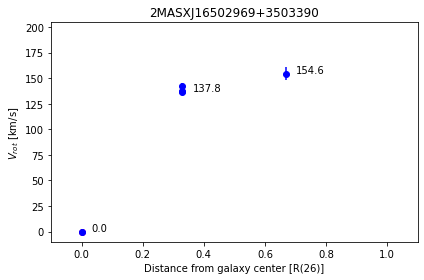

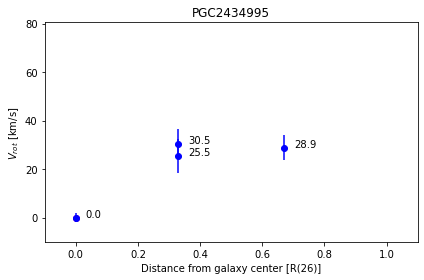

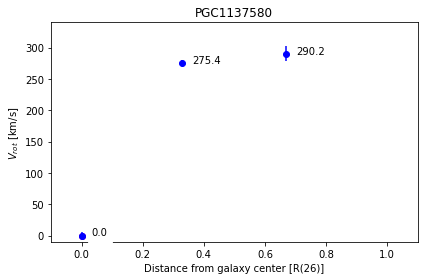

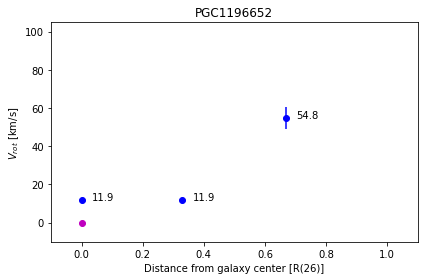

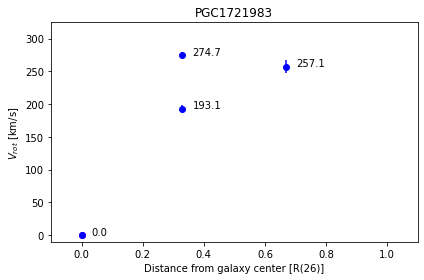

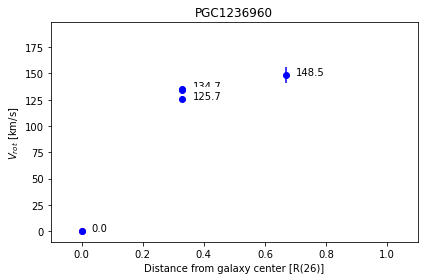

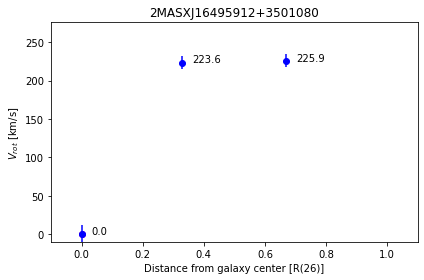

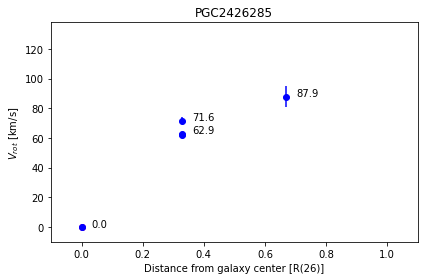

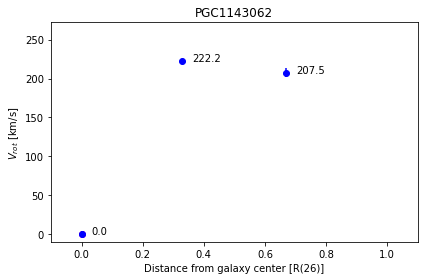

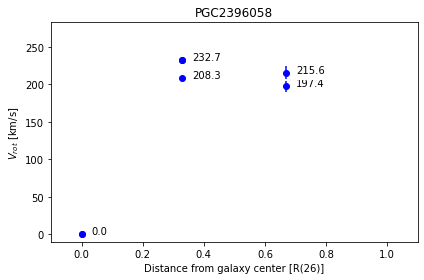

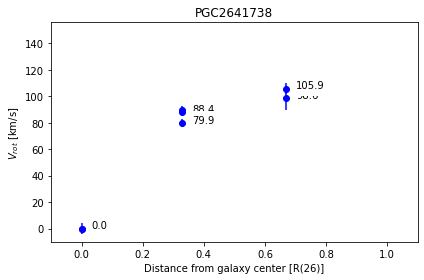

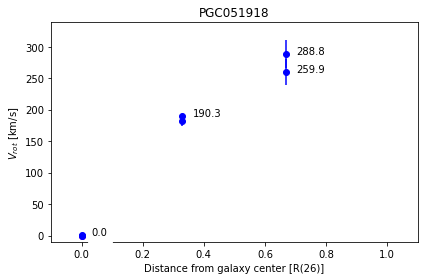

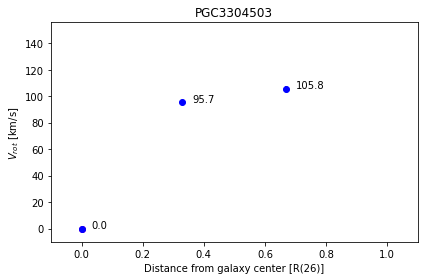

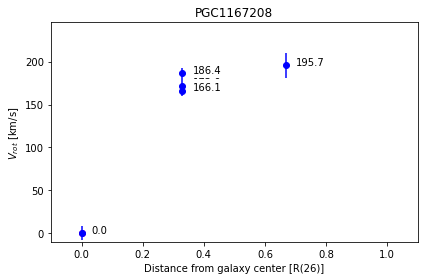

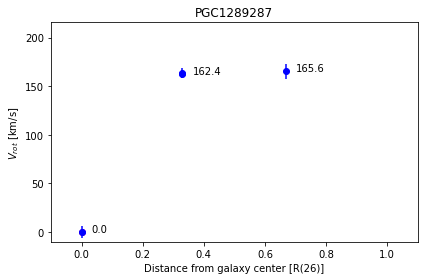

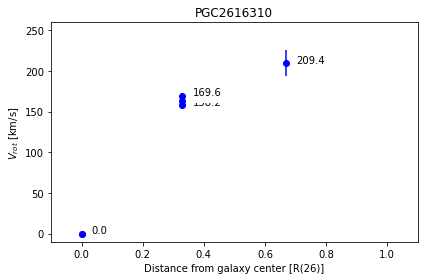

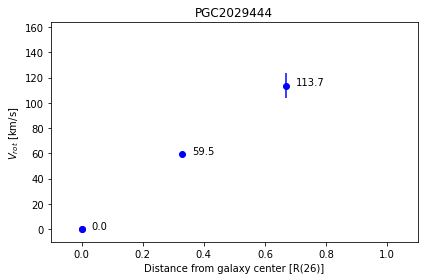

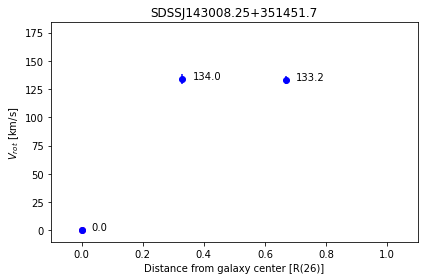

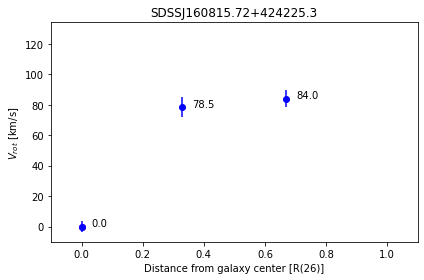

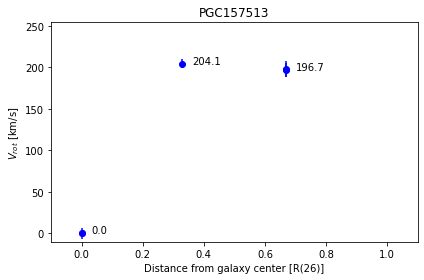

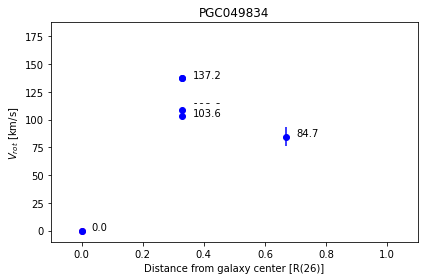

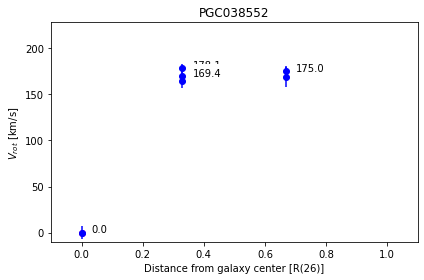

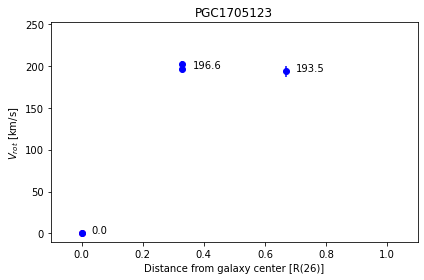

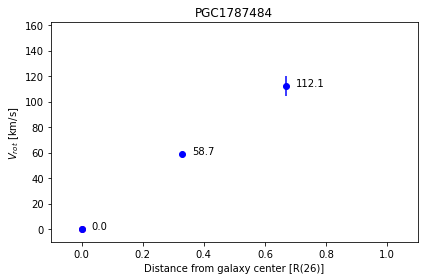

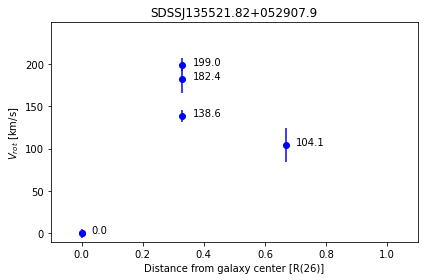

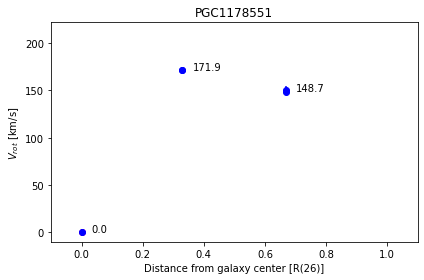

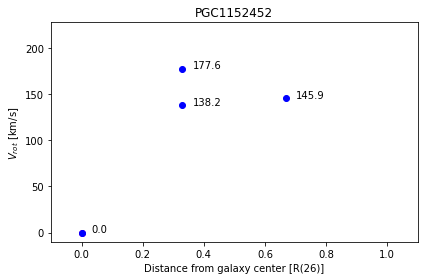

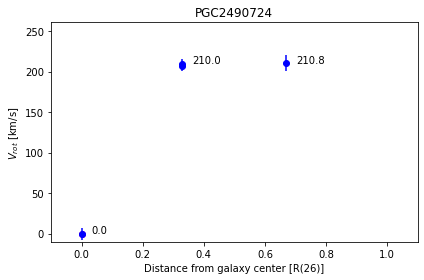

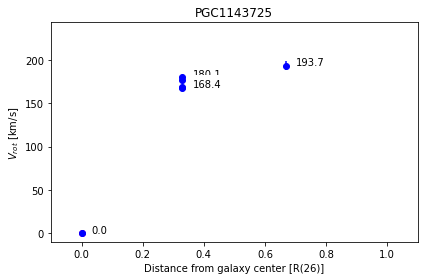

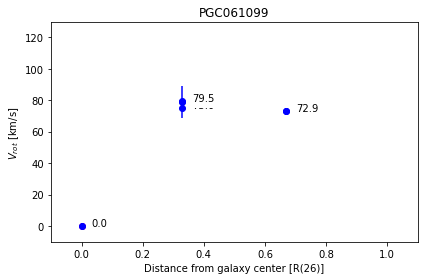

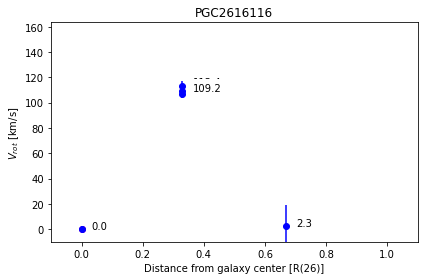

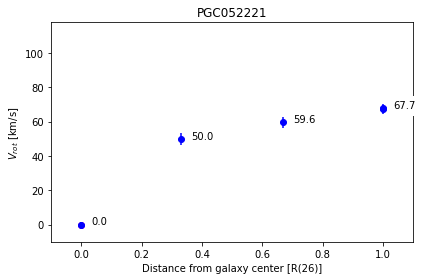

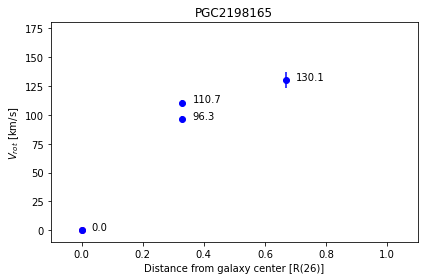

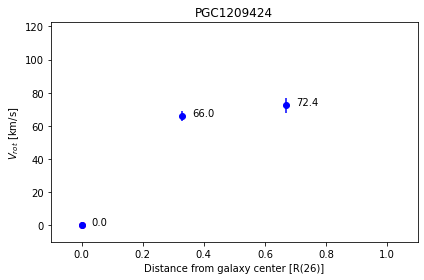

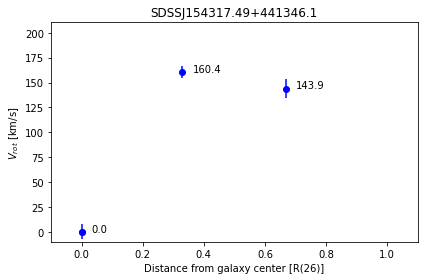

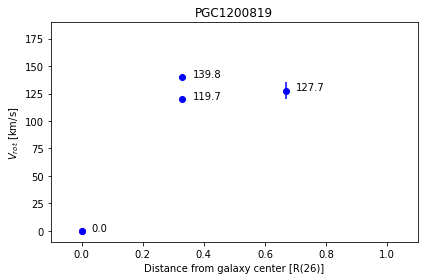

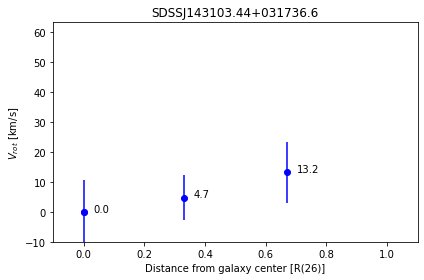

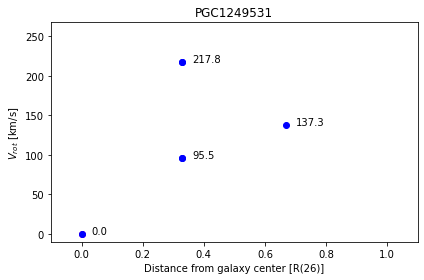

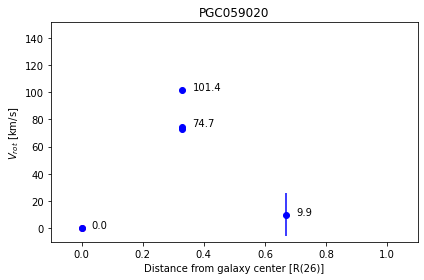

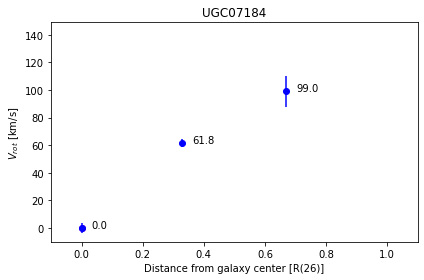

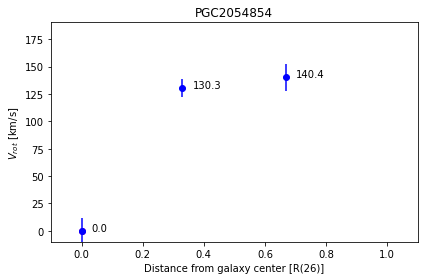

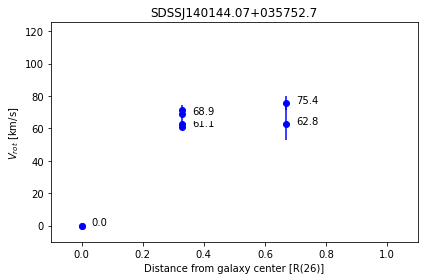

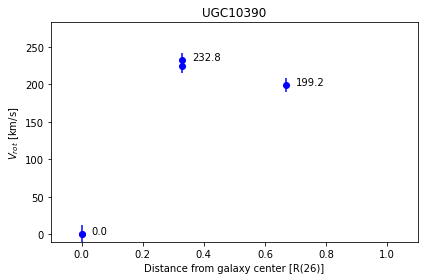

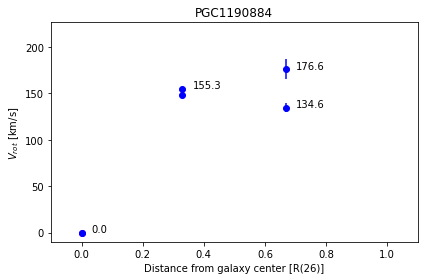

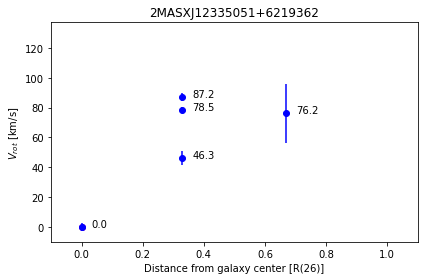

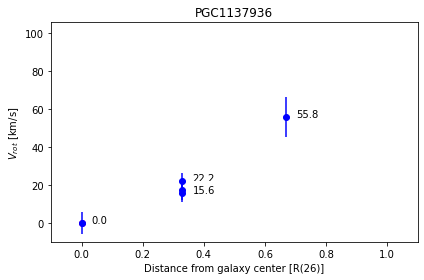

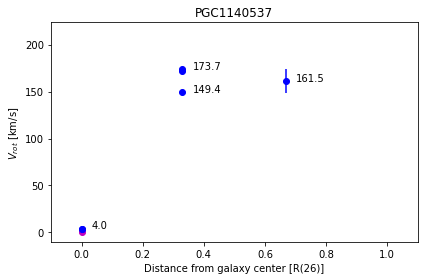

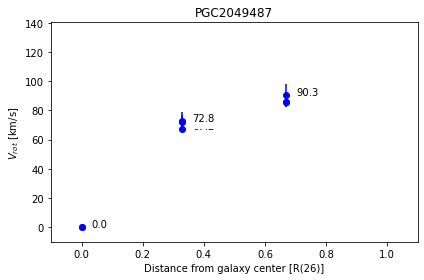

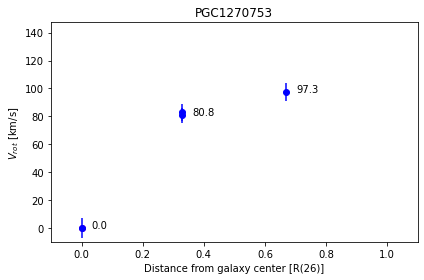

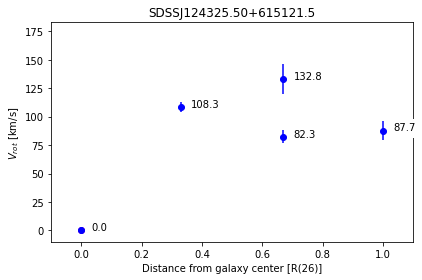

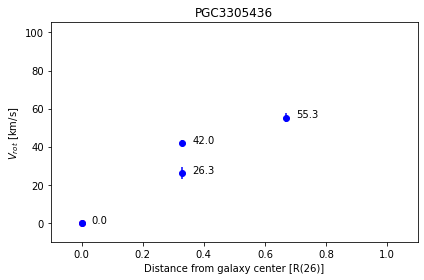

/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3417: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


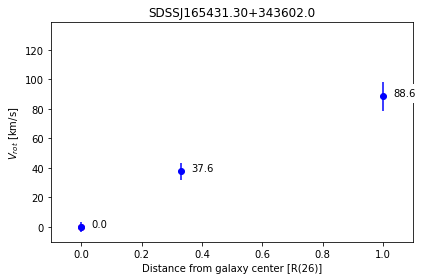

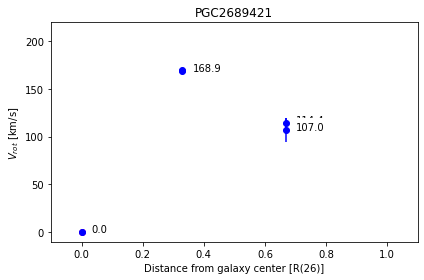

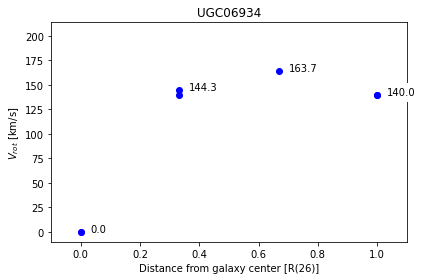

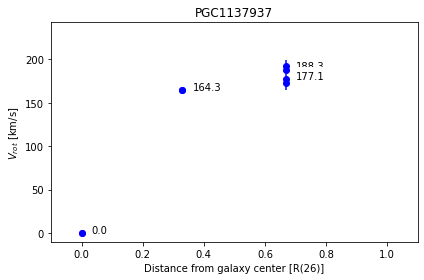

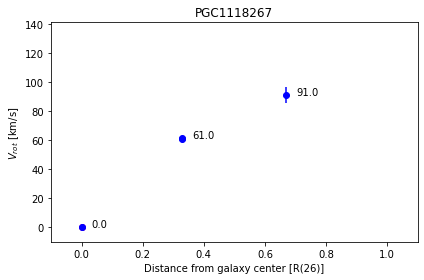

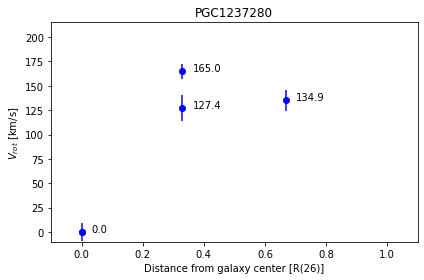

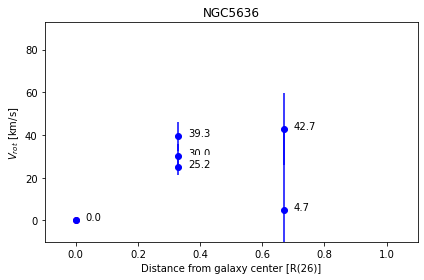

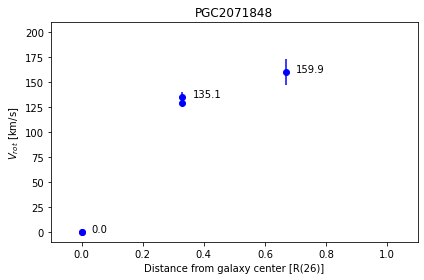

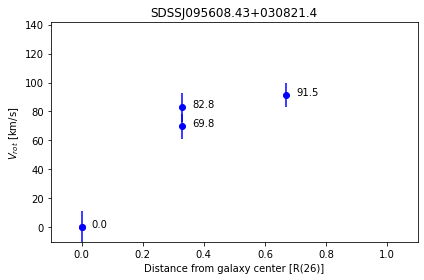

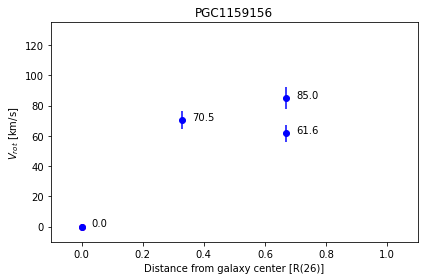

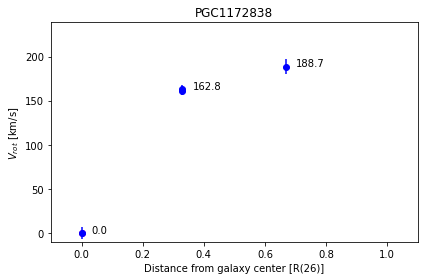

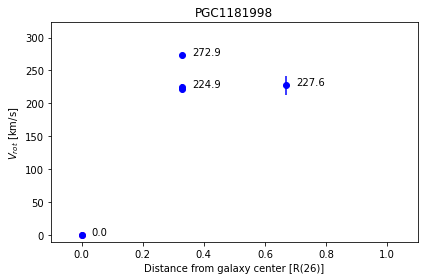

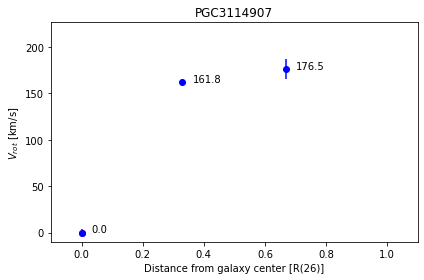

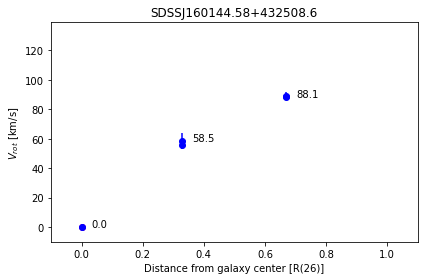

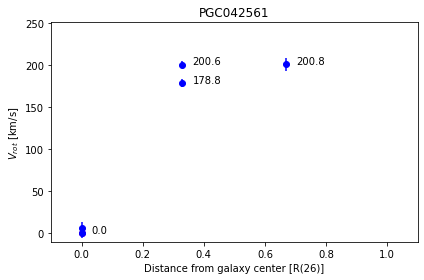

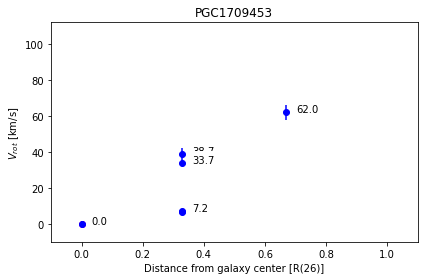

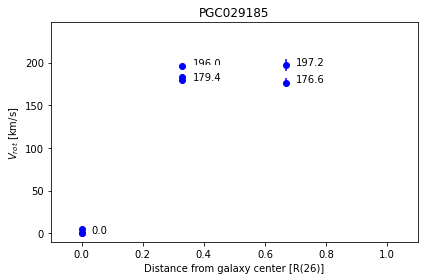

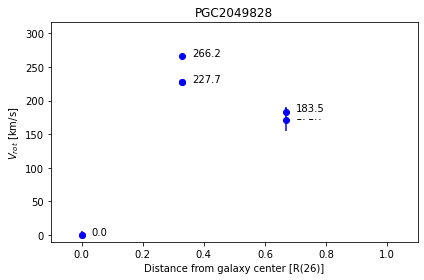

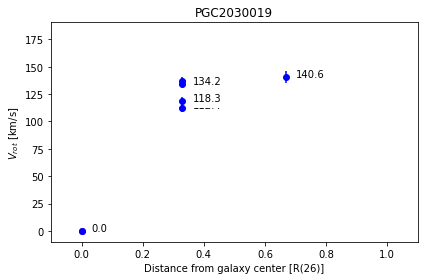

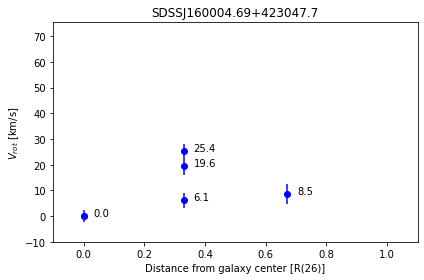

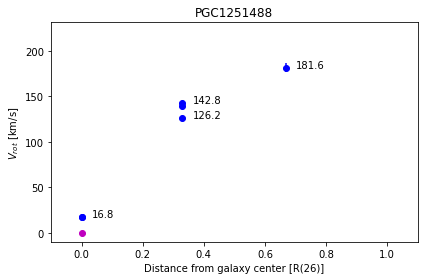

/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3417: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


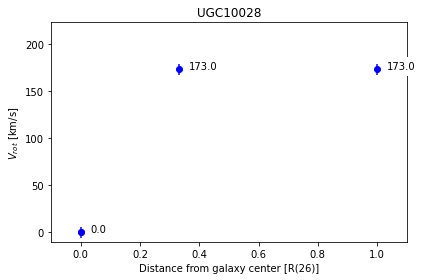

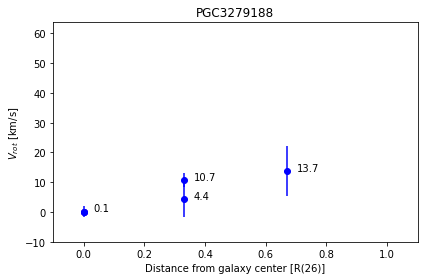

/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3417: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


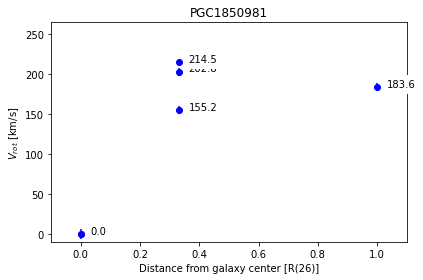

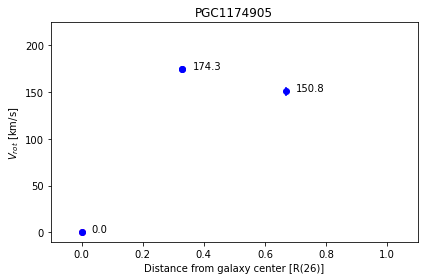

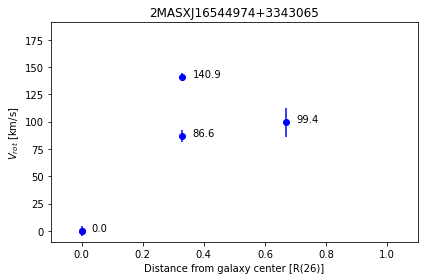

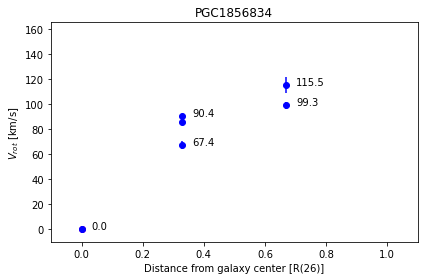

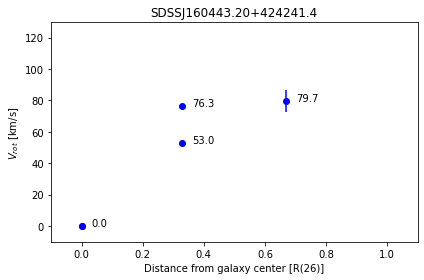

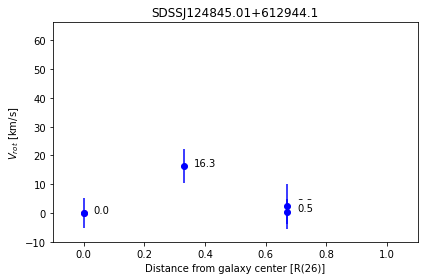

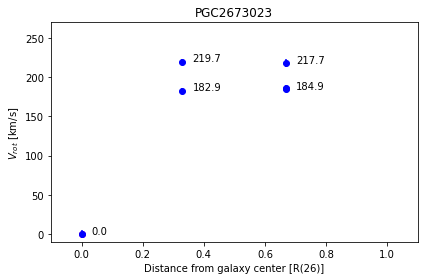

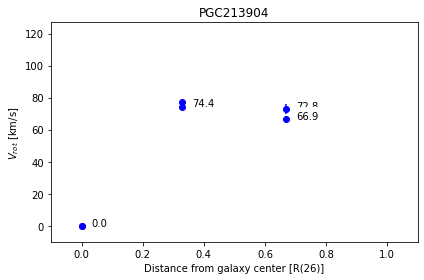

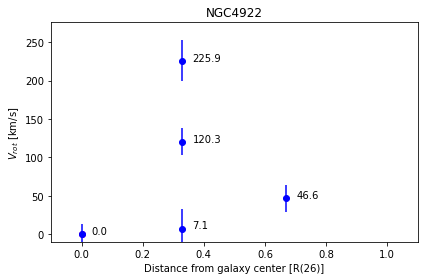

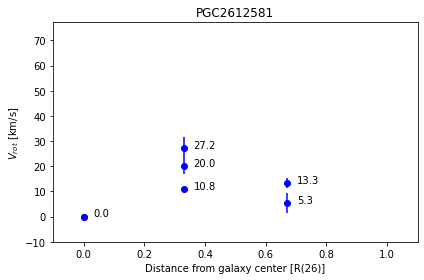

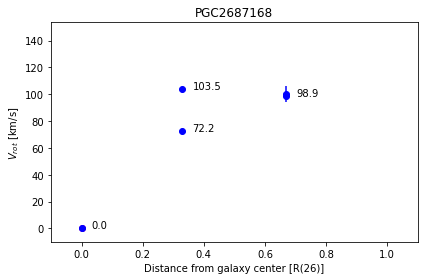

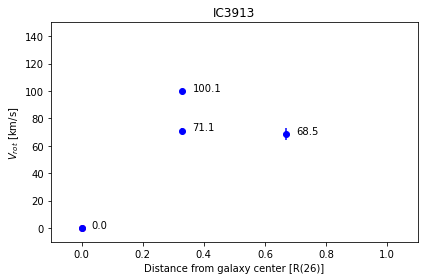

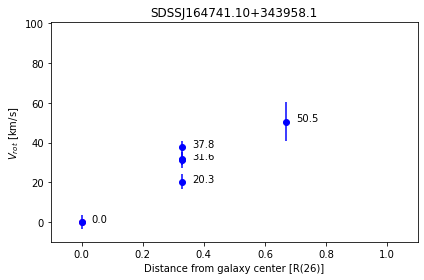

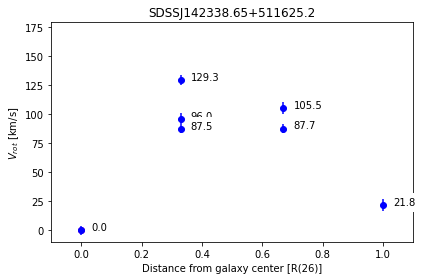

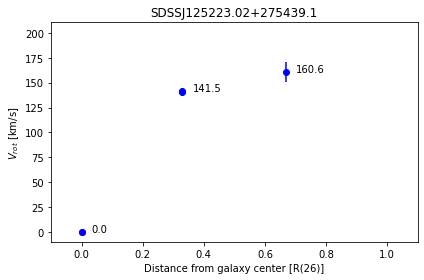

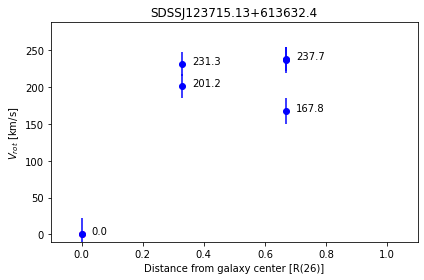

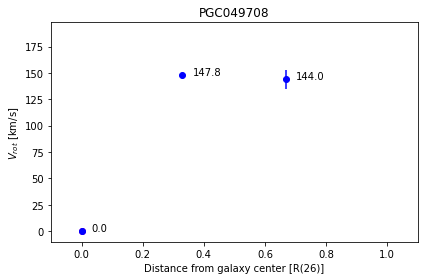

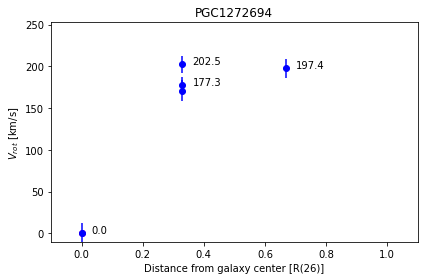

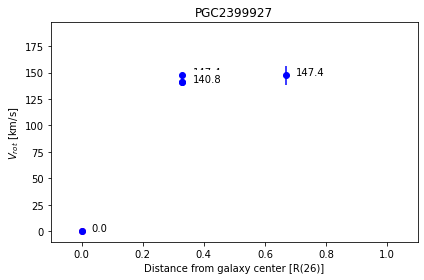

/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3417: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


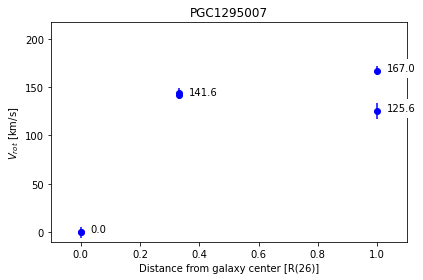

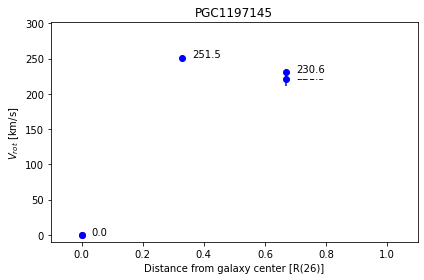

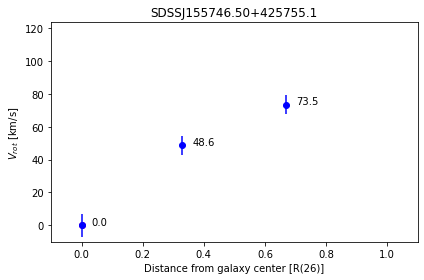

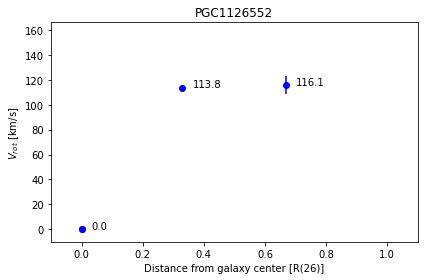

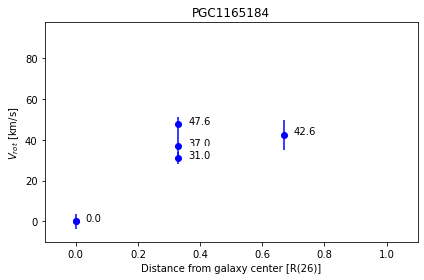

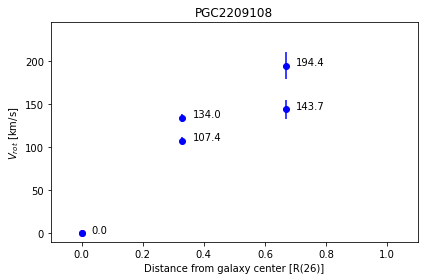

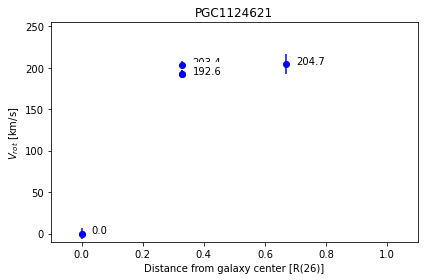

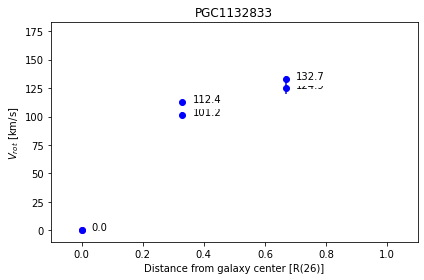

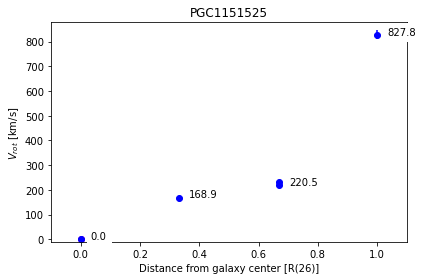

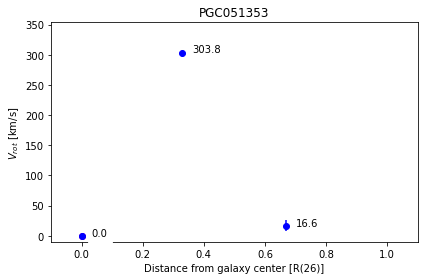

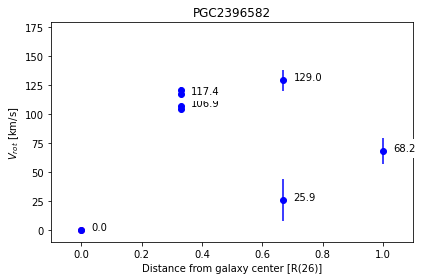

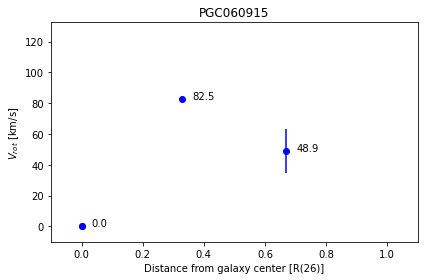

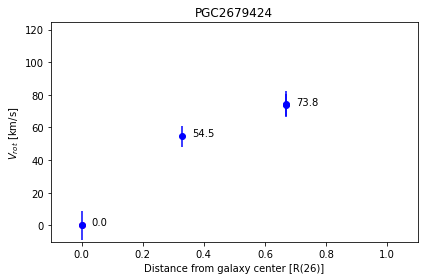

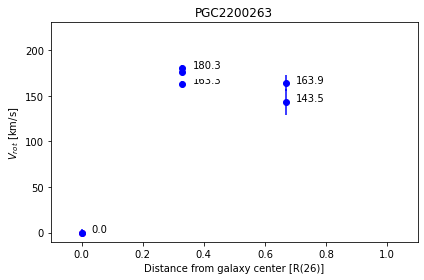

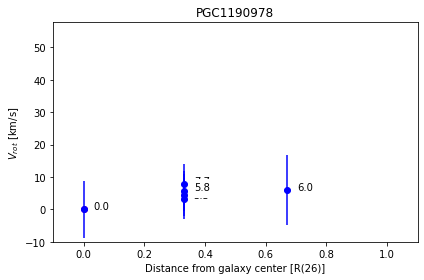

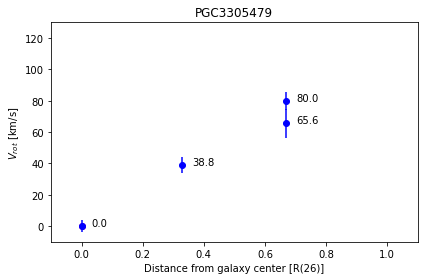

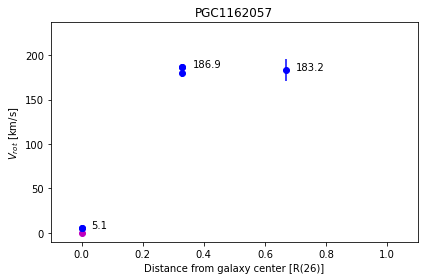

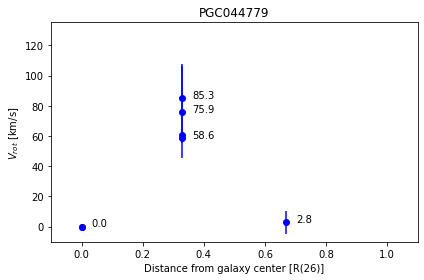

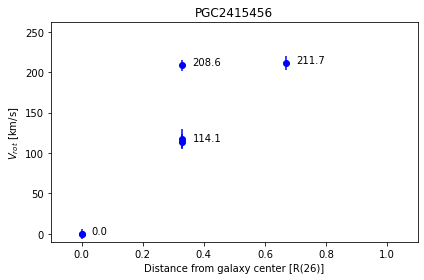

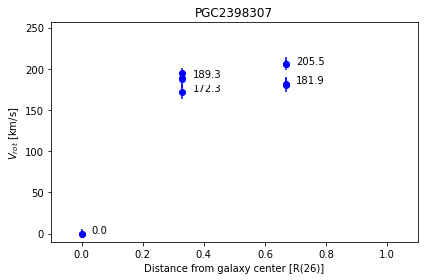

/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3417: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


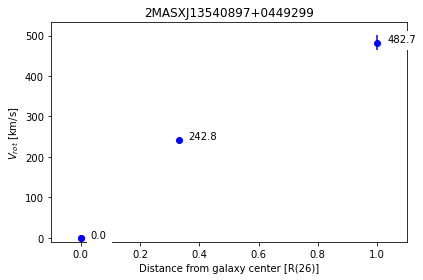

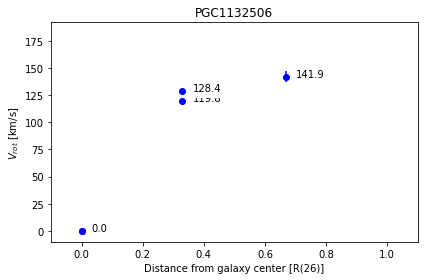

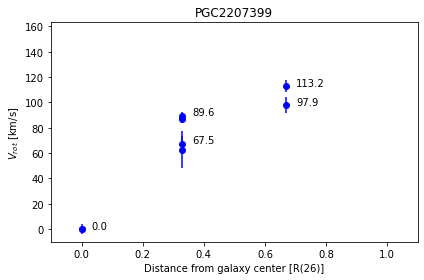

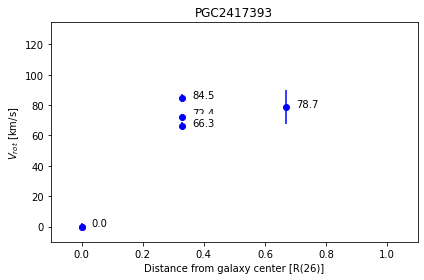

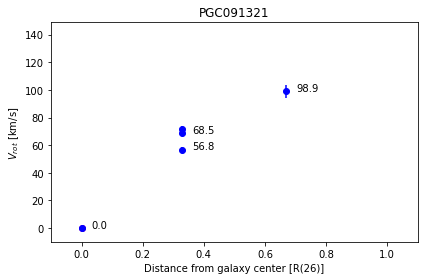

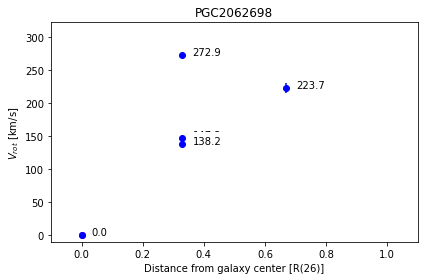

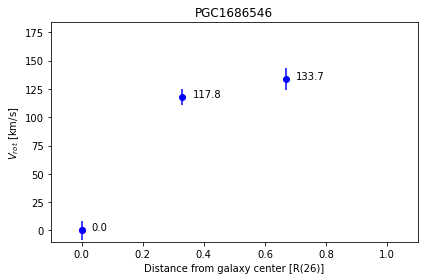

/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3417: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


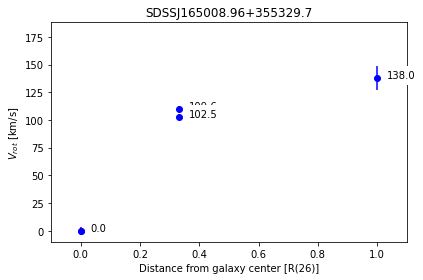

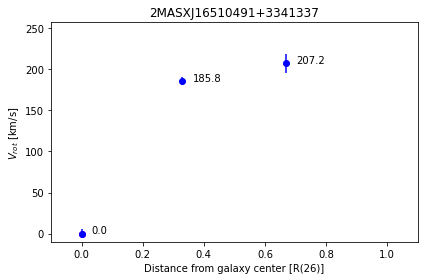

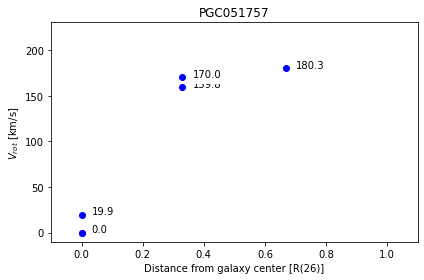

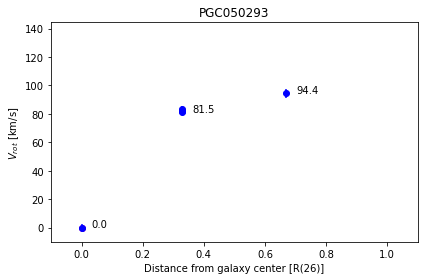

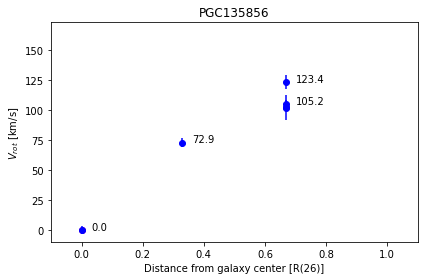

/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3417: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


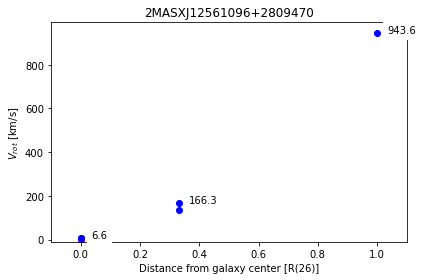

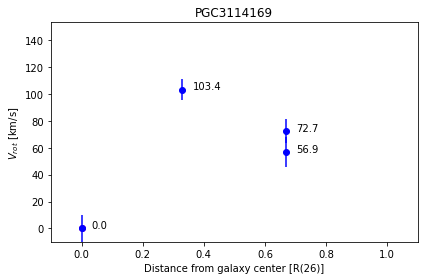

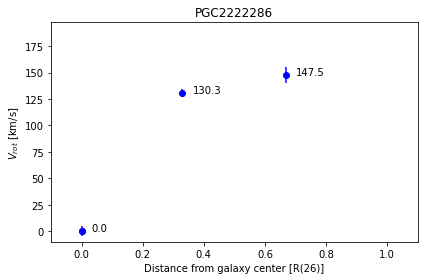

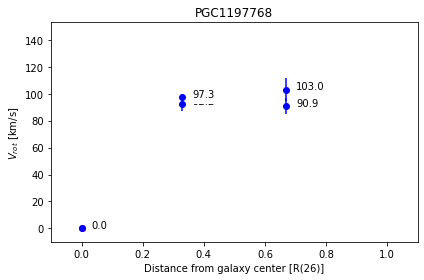

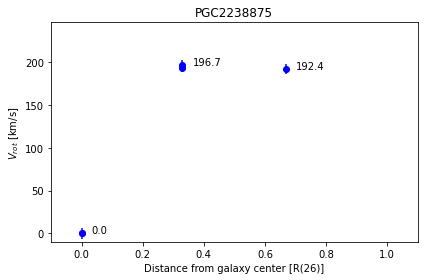

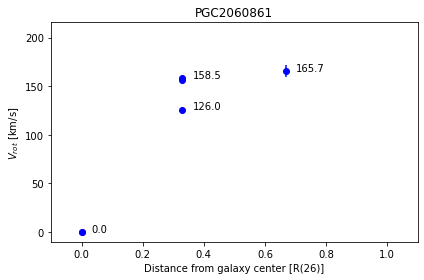

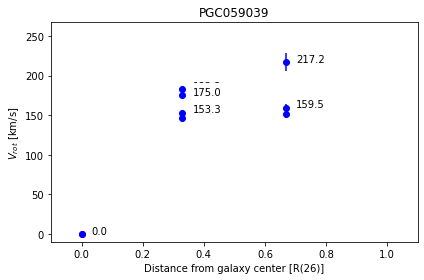

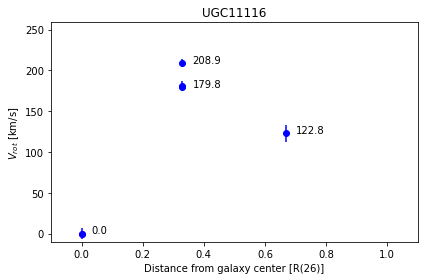

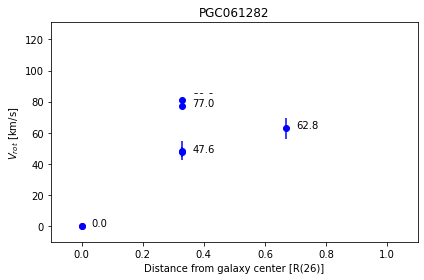

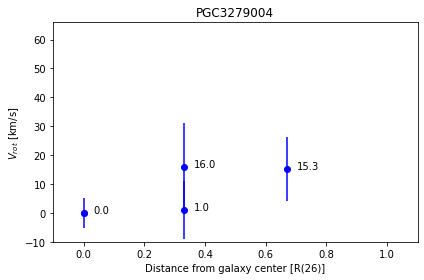

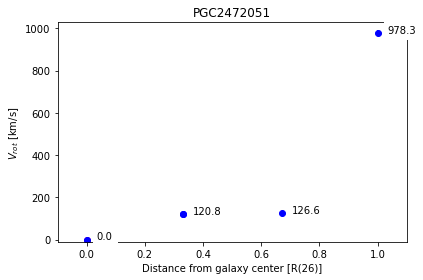

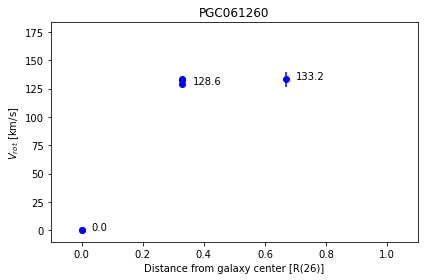

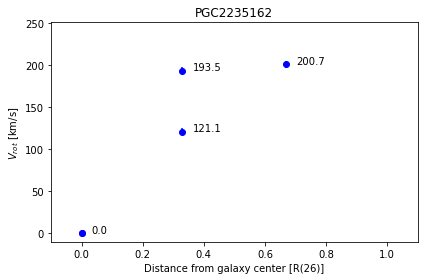

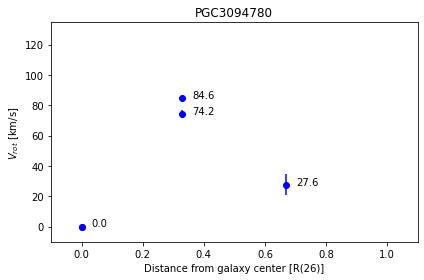

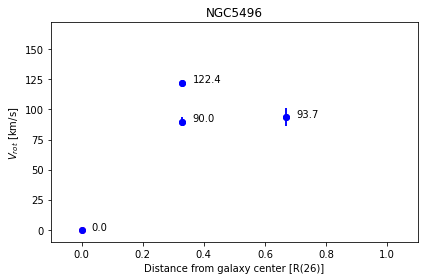

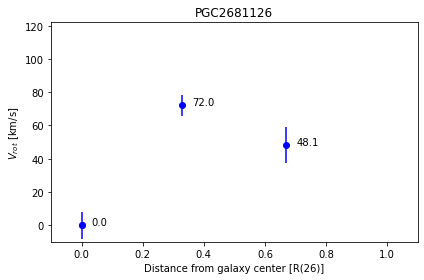

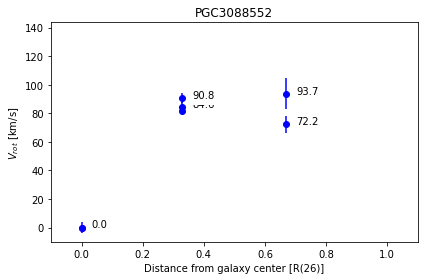

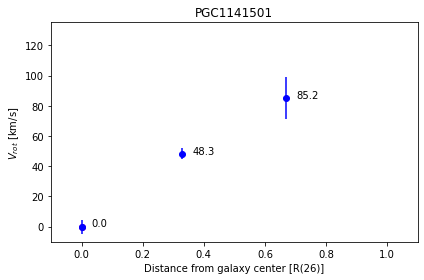

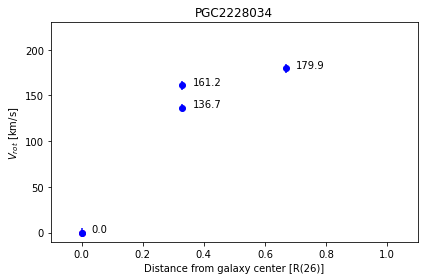

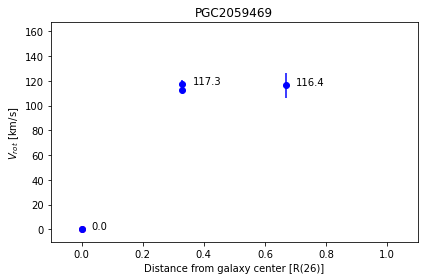

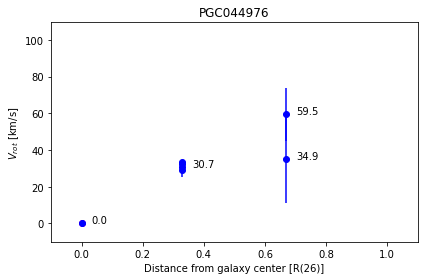

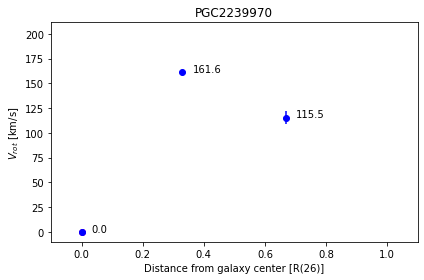

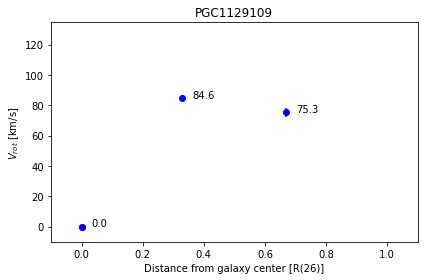

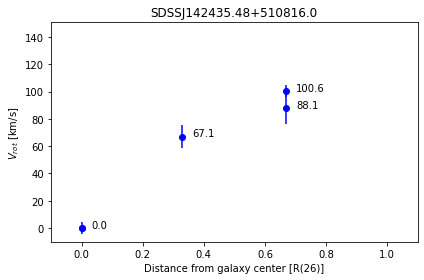

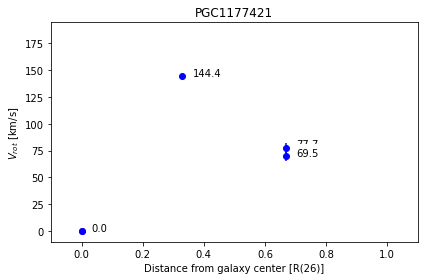

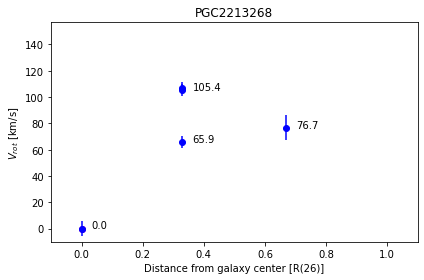

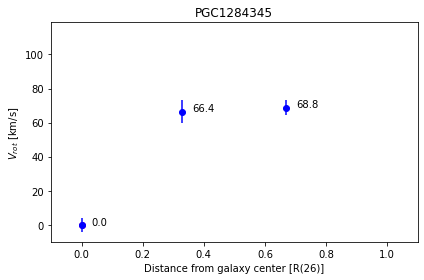

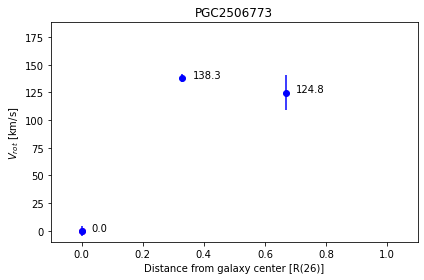

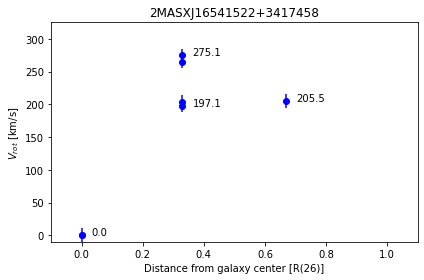

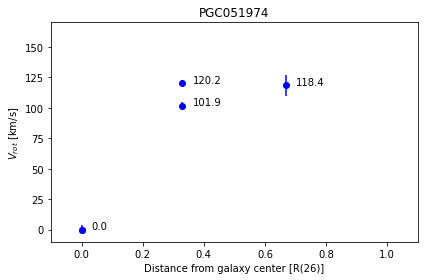

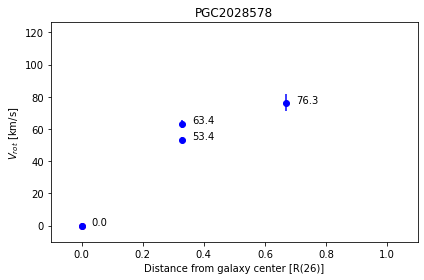

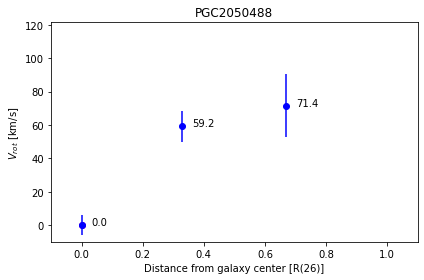

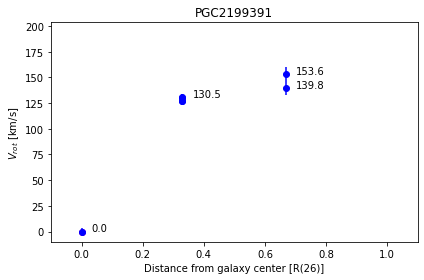

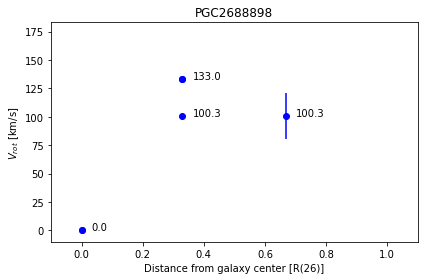

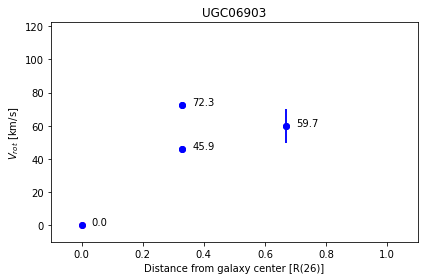

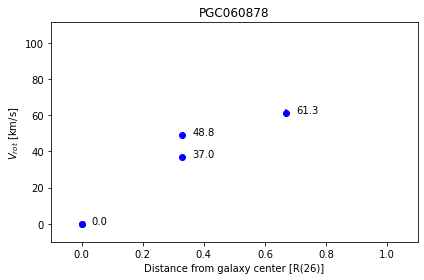

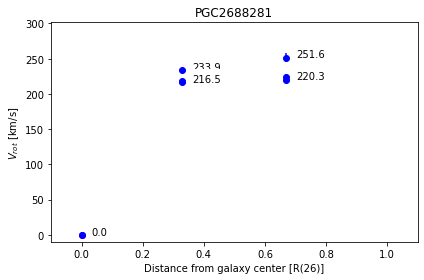

/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3417: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


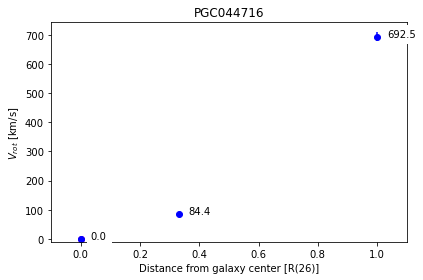

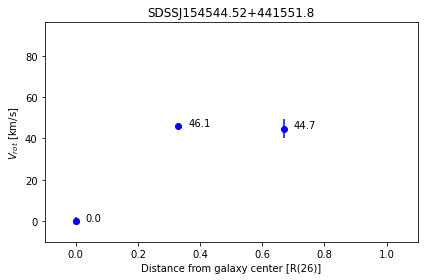

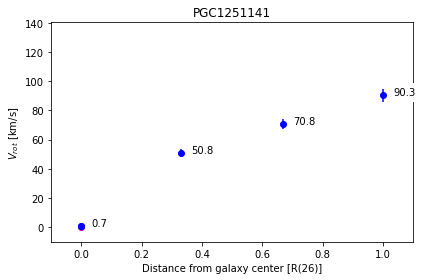

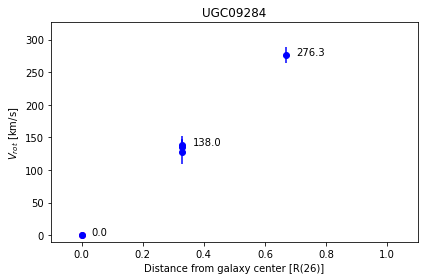

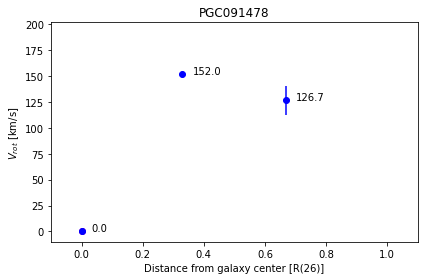

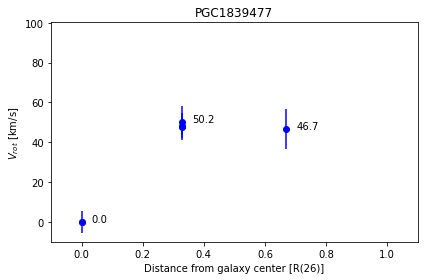

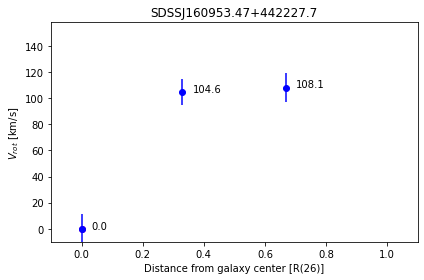

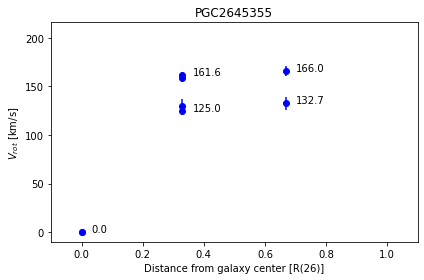

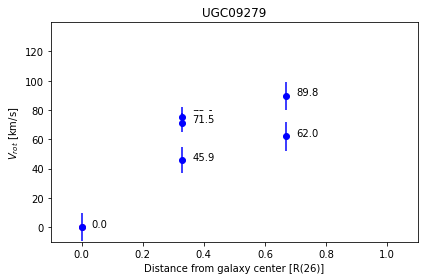

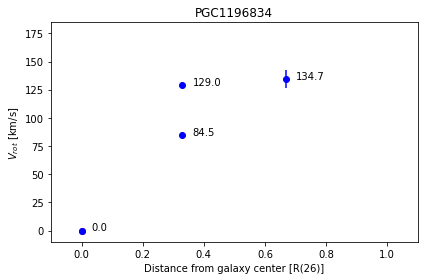

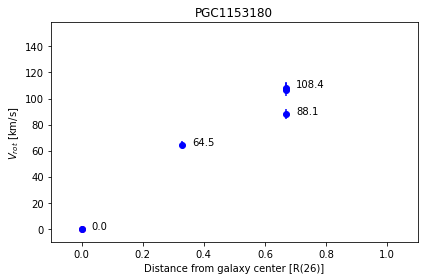

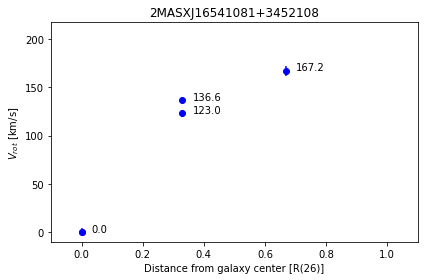

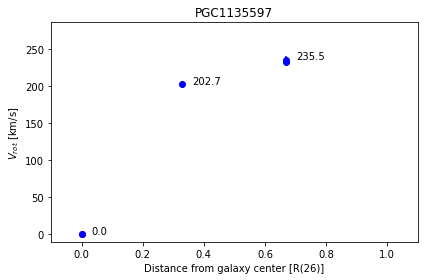

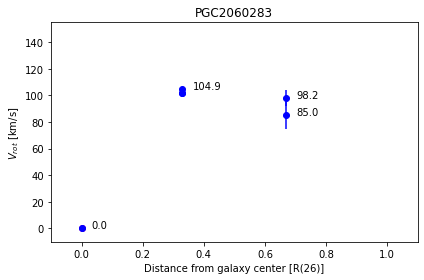

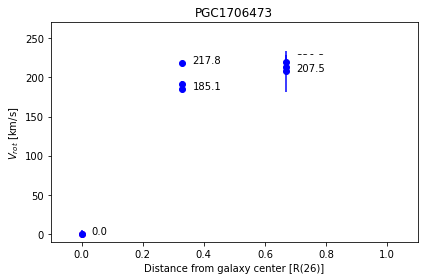

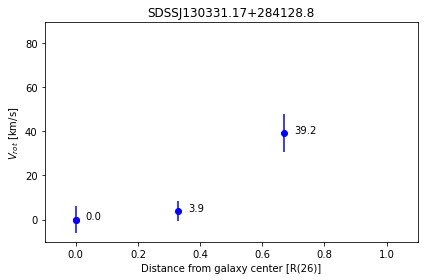

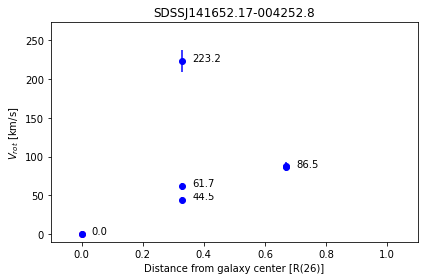

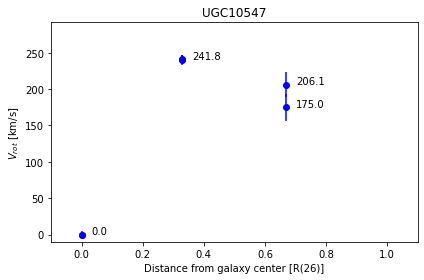

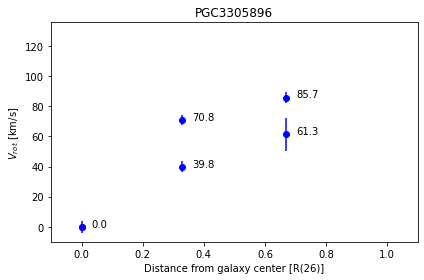

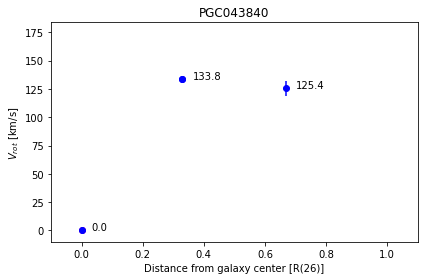

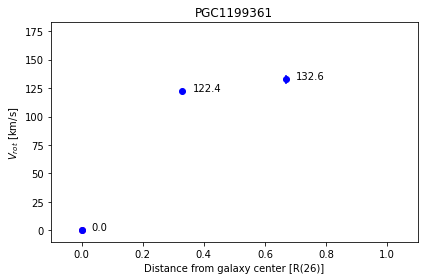

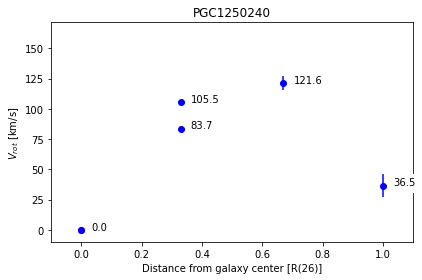

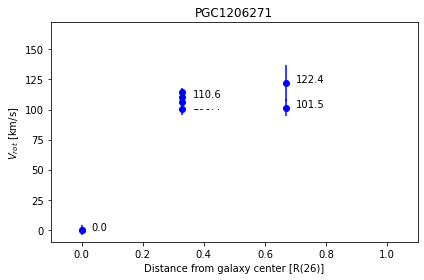

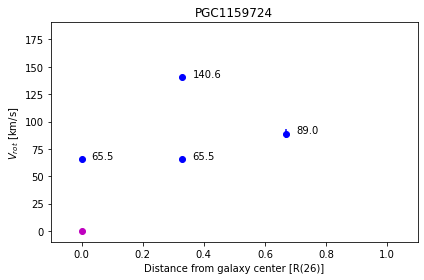

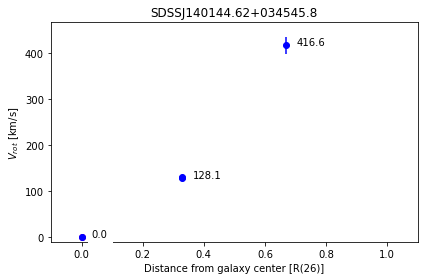

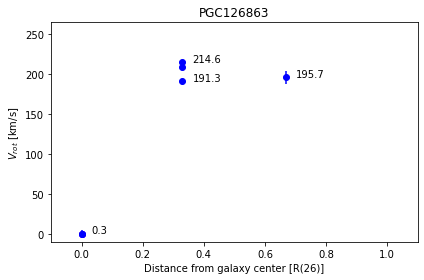

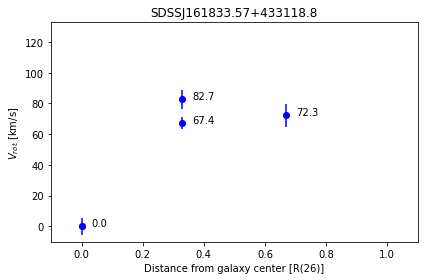

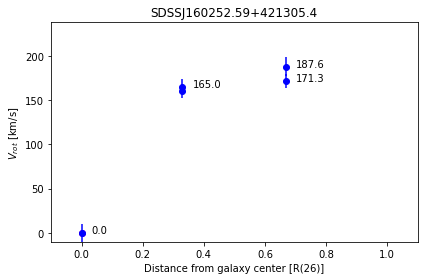

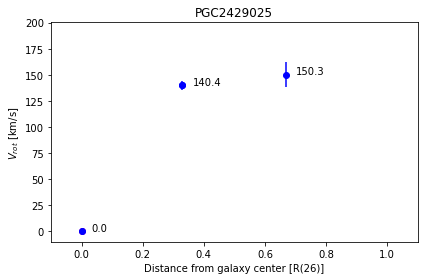

/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3417: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


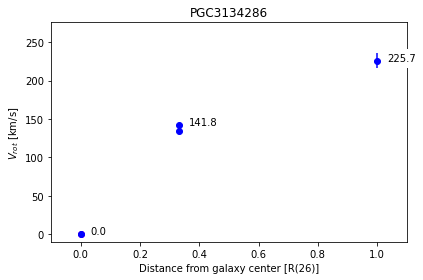

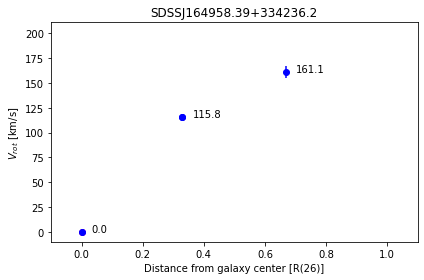

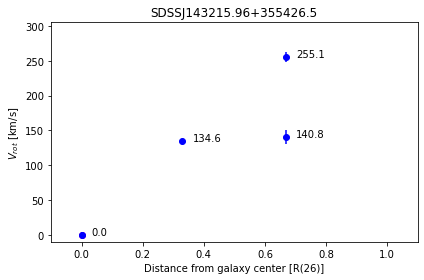

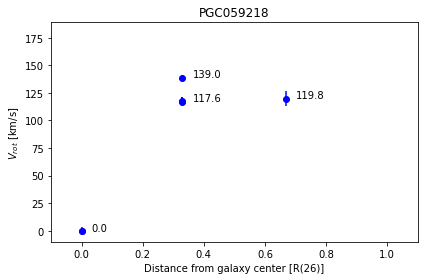

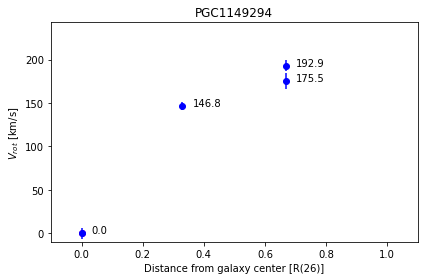

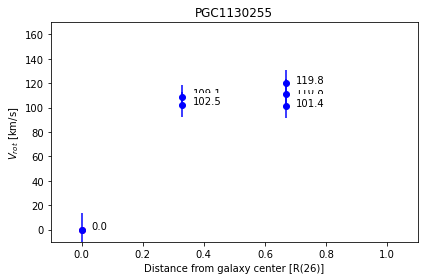

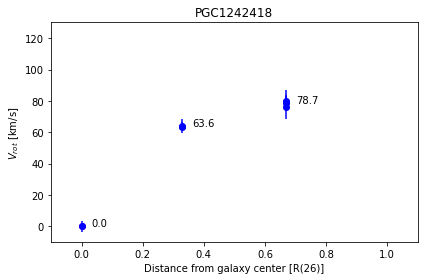

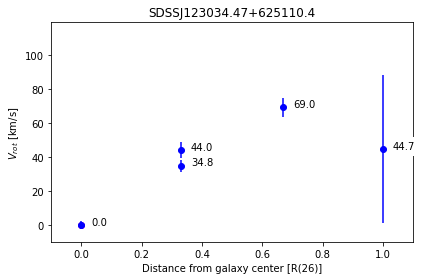

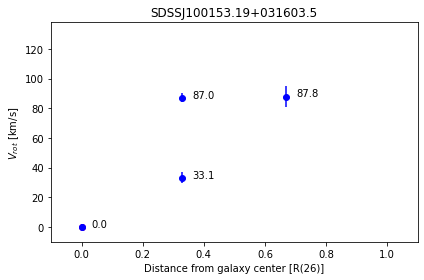

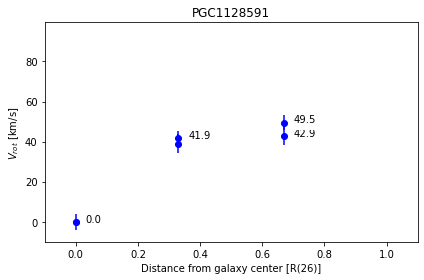

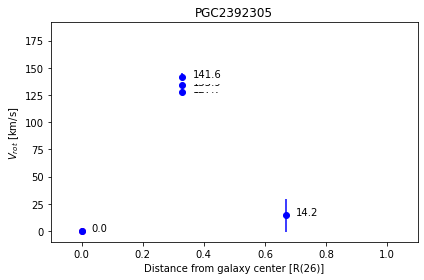

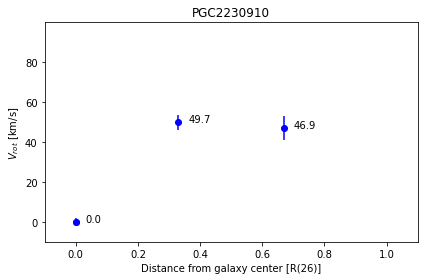

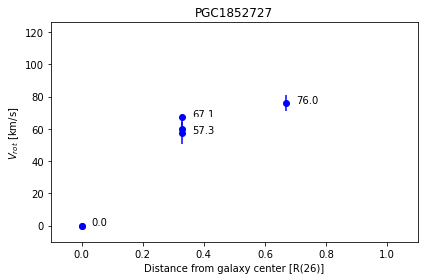

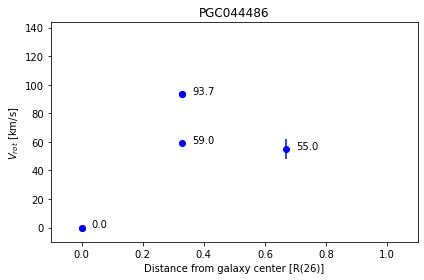

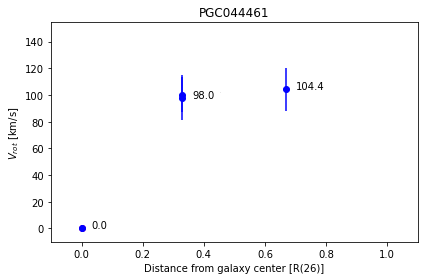

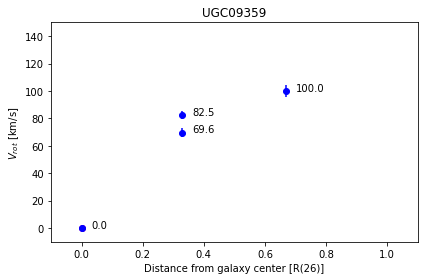

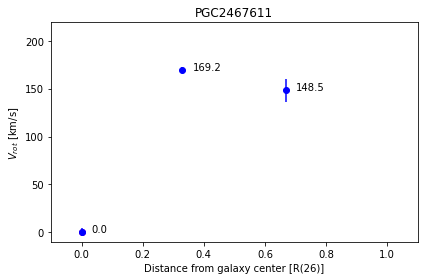

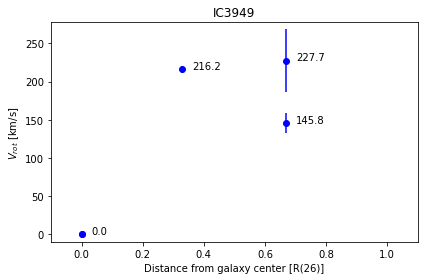

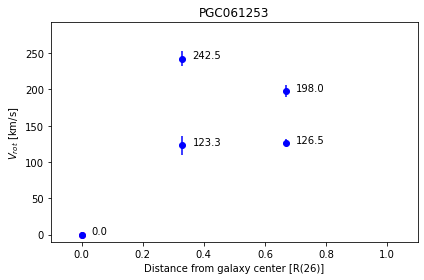

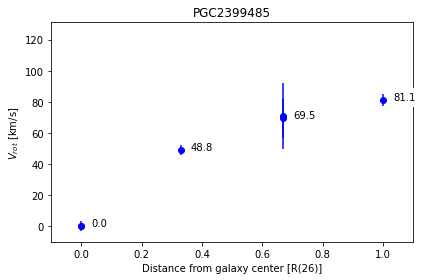

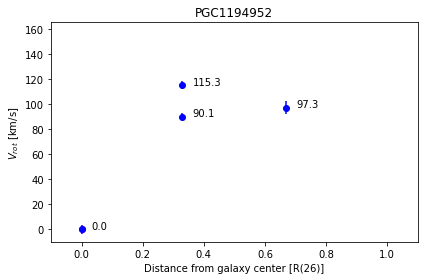

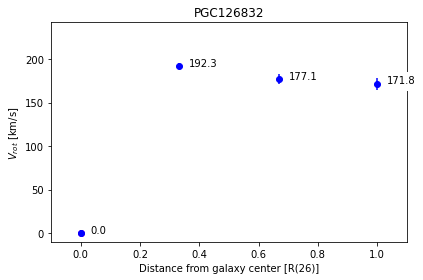

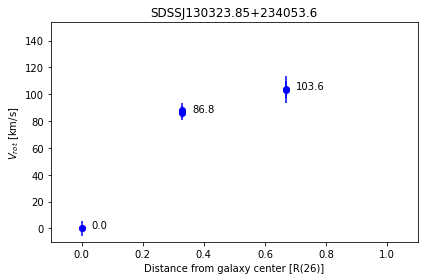

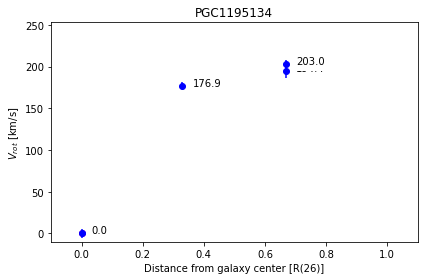

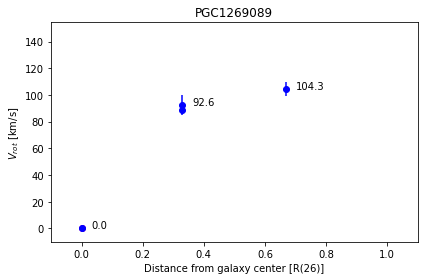

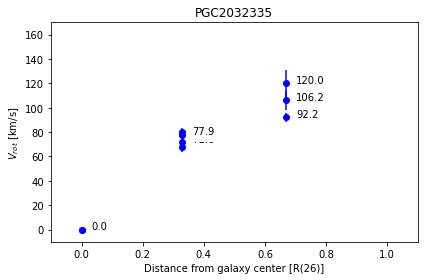

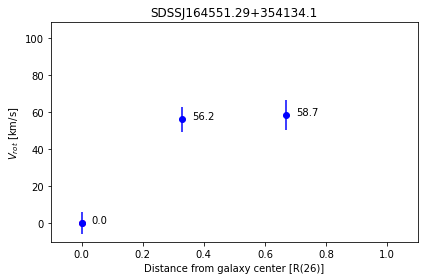

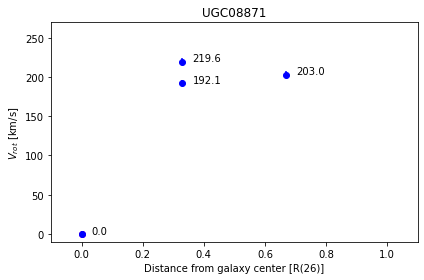

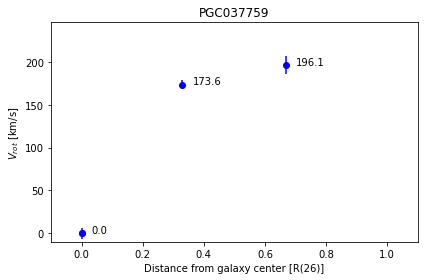

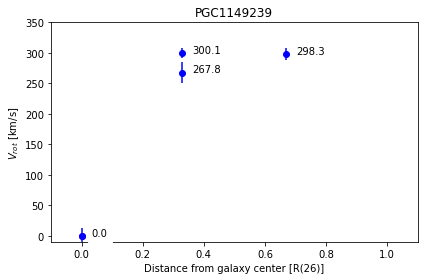

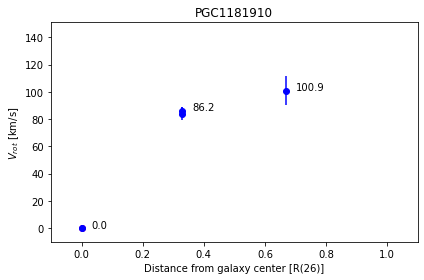

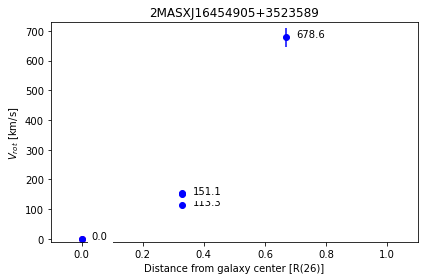

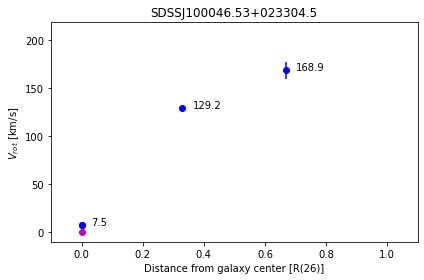

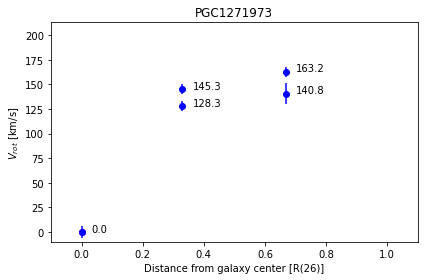

/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3417: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


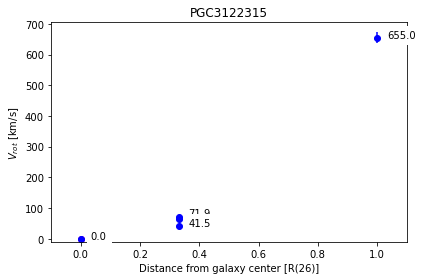

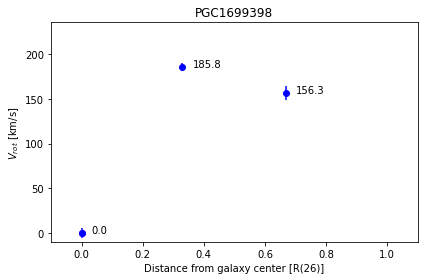

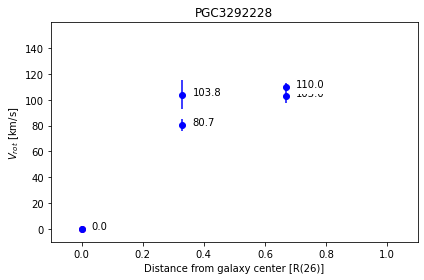

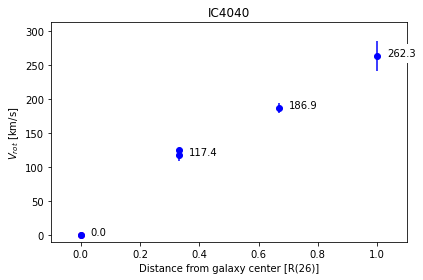

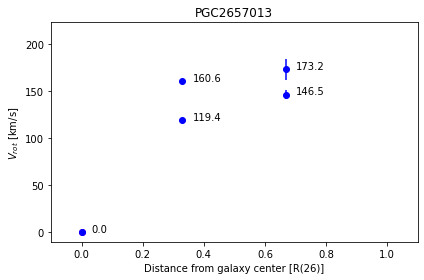

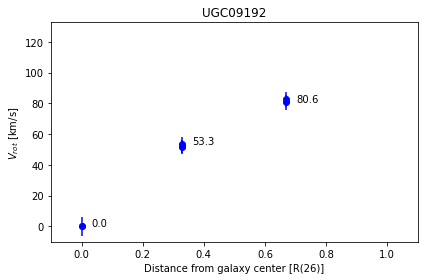

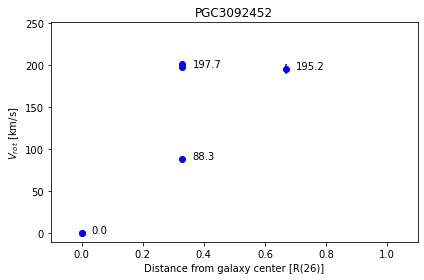

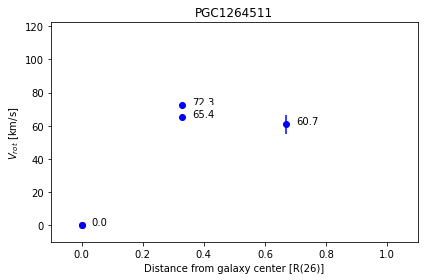

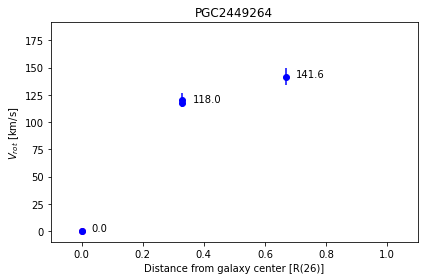

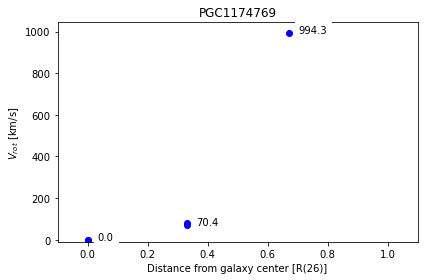

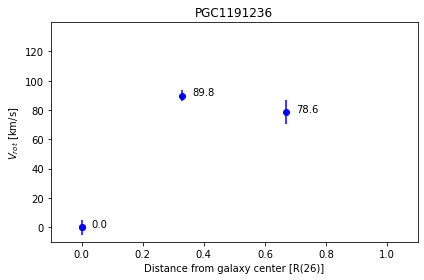

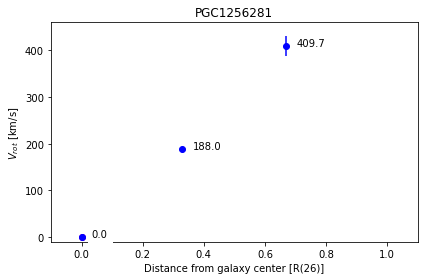

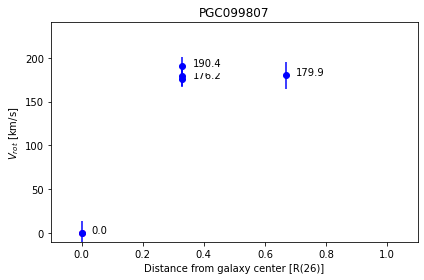

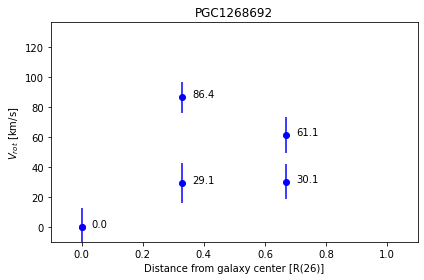

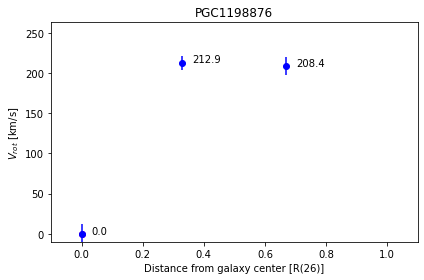

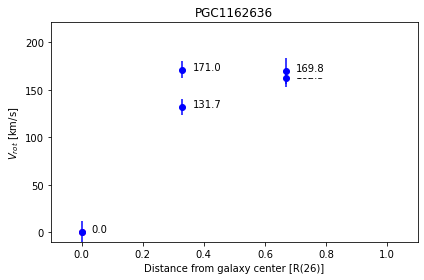

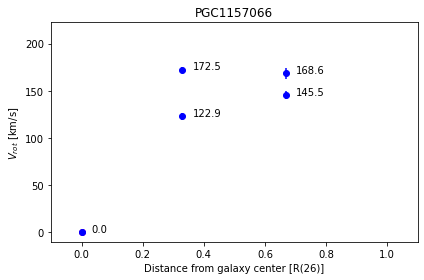

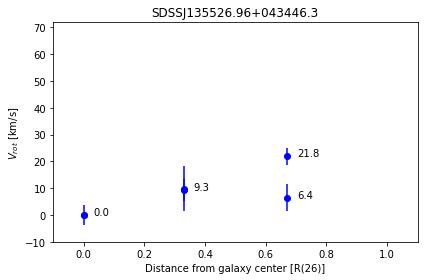

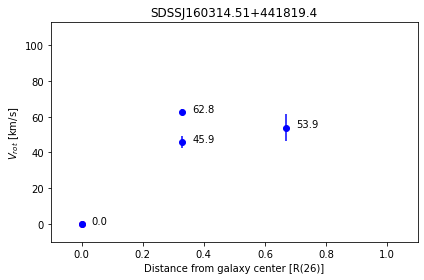

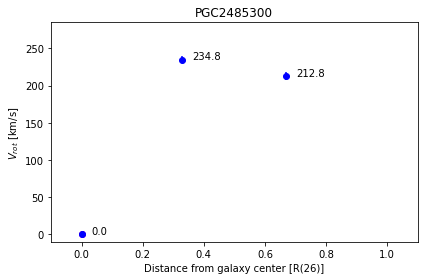

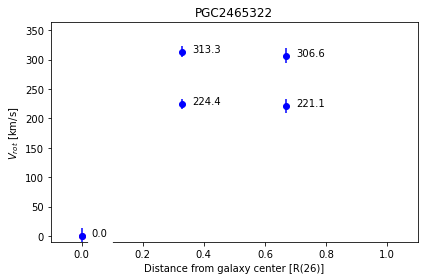

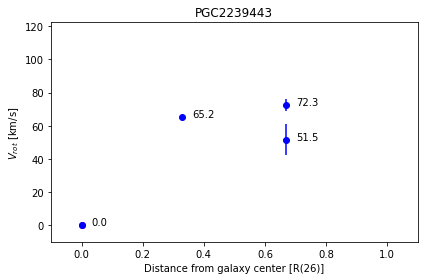

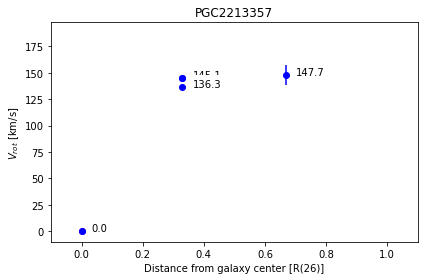

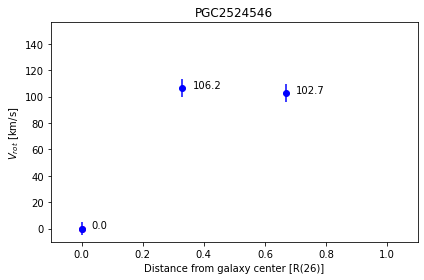

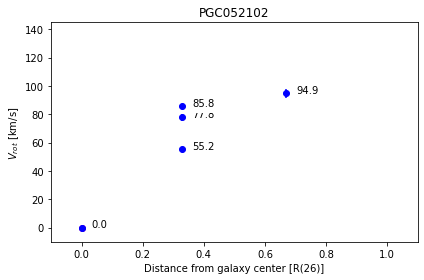

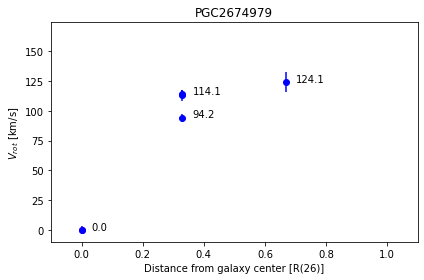

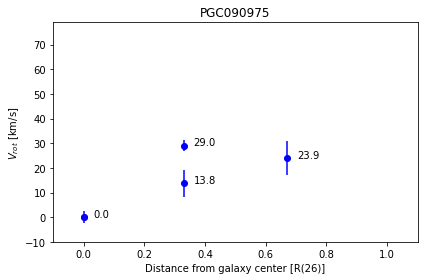

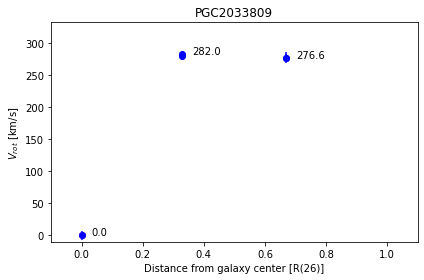

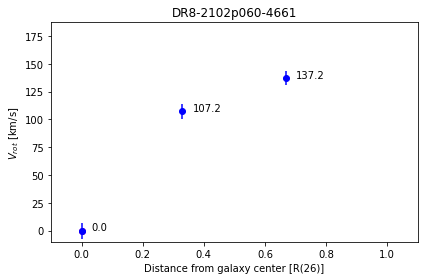

In [12]:
v_diff = []

#for i in np.unique(PV_SGA_ztable['IDX_SGA']):
for i in np.unique(PV_observed['SGA_ID']):
    
    #idx_bool = PV_SGA_ztable['IDX_SGA'] == i
    idx_bool = PV_observed['SGA_ID'] == i
    
    #PV_galaxy = PV_SGA_ztable[idx_bool]
    PV_galaxy = PV_observed[idx_bool]
    
    ################################################################################
    # Do we have a good observation at at least 2 different radii?
    #-------------------------------------------------------------------------------
    good_bool = np.abs(PV_galaxy['V_ROT']) < 1000#*u.km/u.s
    
    #num_0p3 = np.sum(np.logical_and(PV_galaxy['RADIUS'][good_bool] > 0.3, 
    #                                PV_galaxy['RADIUS'][good_bool] < 0.35))
    num_0p3 = np.sum((PV_galaxy['SKY_FIBER_DIST_R26'][good_bool] > 0.3) & (PV_galaxy['SKY_FIBER_DIST_R26'][good_bool] < 0.35))
    
    #num_0p6 = np.sum(np.logical_and(PV_galaxy['RADIUS'][good_bool] > 0.6, 
    #                                PV_galaxy['RADIUS'][good_bool] < 0.7))
    num_0p6 = np.sum((PV_galaxy['SKY_FIBER_DIST_R26'][good_bool] > 0.6) & (PV_galaxy['SKY_FIBER_DIST_R26'][good_bool] < 0.7))

    #num_1 = np.sum(PV_galaxy['RADIUS'][good_bool] > 0.95)
    num_1 = np.sum(PV_galaxy['SKY_FIBER_DIST_R26'][good_bool] > 0.95)
    
    check = [num_0p3 > 0, num_0p6 > 0, num_1 > 0]
    
    if sum(check) > 1:
        #print(PV_galaxy['RADIUS', 'V_ROT'])
        ymax = np.max(np.abs(PV_galaxy['V_ROT'][np.abs(PV_galaxy['V_ROT']) < 1000]))#*u.km/u.s]))
        
        ############################################################################
        # Calculate the difference between the velocity measured at 0.6 and 0.3 R26
        #---------------------------------------------------------------------------
        v0p3 = PV_galaxy['V_ROT'][np.logical_and.reduce([good_bool, 
                                                         #PV_galaxy['RADIUS'] > 0.3, 
                                                         PV_galaxy['SKY_FIBER_DIST_R26'] > 0.3,
                                                         #PV_galaxy['RADIUS'] < 0.35]
                                                         PV_galaxy['SKY_FIBER_DIST_R26'] < 0.35]
                                                        )]
        v0p6 = PV_galaxy['V_ROT'][np.logical_and.reduce([good_bool, 
                                                         #PV_galaxy['RADIUS'] > 0.6, 
                                                         PV_galaxy['SKY_FIBER_DIST_R26'] > 0.6, 
                                                         #PV_galaxy['RADIUS'] < 0.7]
                                                         PV_galaxy['SKY_FIBER_DIST_R26'] < 0.7]
                                                        )]
        
        dv = np.mean(np.abs(v0p6)) - np.mean(np.abs(v0p3))
        v_diff.append(dv)#.value)
        ############################################################################
        
        
        ############################################################################
        # Plot rotation curve
        #---------------------------------------------------------------------------
        plt.figure()
        plt.title(SGA['GALAXY'][SGA['SGA_ID'] == i][0])
        plt.plot(0, 0, 'mo')
        
        plt.errorbar(#PV_galaxy['RADIUS'][PV_galaxy['SPECTYPE'] == 'GALAXY'], 
                     PV_galaxy['SKY_FIBER_DIST_R26'],
                     np.abs(PV_galaxy['V_ROT']), 
                     yerr=PV_galaxy['V_ROT_ERR'], 
                     fmt='o', c='b')

        for (r,v) in zip(PV_galaxy['SKY_FIBER_DIST_R26'], np.abs(PV_galaxy['V_ROT'])):#zip(PV_galaxy['RADIUS'].data, np.abs(PV_galaxy['V_ROT'].data)):
            if v < 1000:
                label = '{:.1f}'.format(v)

                plt.annotate(label, 
                             (r,v), 
                             textcoords='offset points', 
                             xytext=(10,0), 
                             backgroundcolor='white')
        
        plt.xlim((-0.1, 1.1))
        plt.ylim((-10,ymax + 50))#.value + 50))
        
        plt.xlabel('Distance from galaxy center [R(26)]')
        plt.ylabel('$V_{rot}$ [km/s]')
        plt.tight_layout()

        plt.show()
        plt.close()
        ############################################################################
    ################################################################################
    
    #break

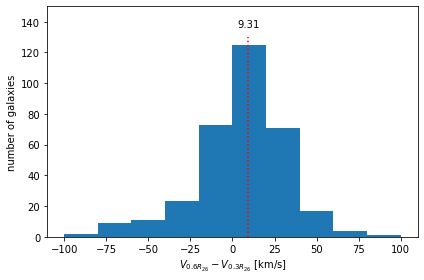

In [20]:
#print(np.nanmedian(v_diff))

plt.figure(tight_layout=True)

plt.hist(np.array(v_diff), bins=np.linspace(-100,100,11))
plt.vlines(np.nanmedian(v_diff), 0,130, colors='r', linestyles=':')

plt.annotate('{:.2f}'.format(np.nanmedian(v_diff)), 
             (np.nanmedian(v_diff), 130), 
             textcoords='offset points', 
             xytext=(0,10), 
             #backgroundcolor='white', 
             ha='center')

plt.ylim(ymax=150)

plt.xlabel('$V_{0.6R_{26}} - V_{0.3R_{26}}$ [km/s]')
plt.ylabel('number of galaxies')

plt.savefig('../images/fuji_vdiff.png', dpi=300, transparent=True)

# Observation statistics

## What is the distribution of velocity differences at $0.3R_{26}$ and $0.6R_{26}$?

In [10]:
r0p3 = (PV_observed['SKY_FIBER_DIST_R26'] > 0.3) & (PV_observed['SKY_FIBER_DIST_R26'] < 0.35)
r0p6 = (PV_observed['SKY_FIBER_DIST_R26'] > 0.6) & (PV_observed['SKY_FIBER_DIST_R26'] < 0.7)
r1 = (PV_observed['SKY_FIBER_DIST_R26'] > 0.95)

In [11]:
v_diff = []

for i in np.unique(PV_observed['SGA_ID']):
    
    idx_bool = PV_observed['SGA_ID'] == i
    
    PV_galaxy = PV_observed[idx_bool]
    
    ############################################################################
    # Do we have any observations at 0.3R26 and 0.6R26?
    #---------------------------------------------------------------------------
    good_bool = np.abs(PV_galaxy['V_ROT']) < 1000 # km/s
    
    num_0p3 = np.sum((PV_galaxy['SKY_FIBER_DIST_R26'][good_bool] > 0.3) & (PV_galaxy['SKY_FIBER_DIST_R26'][good_bool] < 0.35))
    
    num_0p6 = np.sum((PV_galaxy['SKY_FIBER_DIST_R26'][good_bool] > 0.6) & (PV_galaxy['SKY_FIBER_DIST_R26'][good_bool] < 0.7))
    
    check = [num_0p3 > 0, num_0p6 > 0]
    
    if sum(check) > 1:
        
        ########################################################################
        # Calculate the difference between the velocity measured at 0.6 and 0.3 
        # R26
        #-----------------------------------------------------------------------
        v0p3 = PV_galaxy['V_ROT'][np.logical_and.reduce([good_bool, 
                                                         PV_galaxy['SKY_FIBER_DIST_R26'] > 0.3, 
                                                         PV_galaxy['SKY_FIBER_DIST_R26'] < 0.35])]
        v0p6 = PV_galaxy['V_ROT'][np.logical_and.reduce([good_bool, 
                                                         PV_galaxy['SKY_FIBER_DIST_R26'] > 0.6, 
                                                         PV_galaxy['SKY_FIBER_DIST_R26'] < 0.7])]
        
        dv = np.mean(np.abs(v0p6)) - np.mean(np.abs(v0p3))
        v_diff.append(dv)
        ########################################################################
    ############################################################################

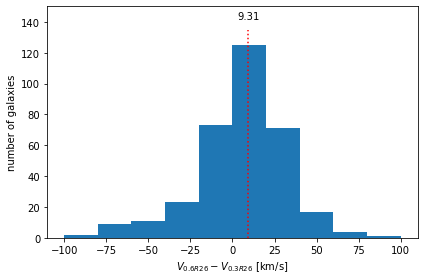

In [12]:
plt.figure(tight_layout=True)

plt.hist(np.array(v_diff), bins=np.linspace(-100, 100, 11))
plt.vlines(np.median(v_diff), 0, 135, colors='r', linestyles=':')

plt.annotate('{:.2f}'.format(np.median(v_diff)), 
             (np.median(v_diff), 135), 
             textcoords='offset points', 
             xytext=(0,10), 
             ha='center')

plt.ylim(ymax=150)

plt.xlabel('$V_{0.6R26} - V_{0.3R26}$ [km/s]')
plt.ylabel('number of galaxies');

### What is the distribution in velocity uncertainties at each radius?

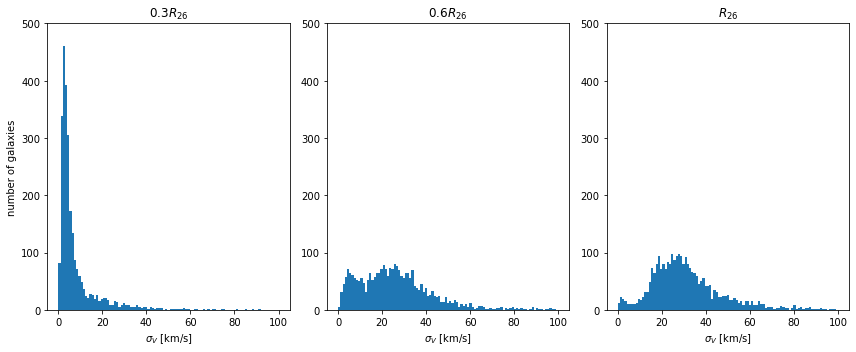

In [13]:
plt.figure(figsize=(12,5), tight_layout=True)

zerr_bins = np.linspace(0,0.002, 50)
verr_bins = np.linspace(0,100, 100)

plt.subplot(131)
plt.hist(PV_observed['V_ROT_ERR'][r0p3], bins=verr_bins)
plt.title('$0.3R_{26}$')
plt.xlabel('$\sigma_V$ [km/s]')
plt.ylabel('number of galaxies')
plt.ylim(ymax=500)

plt.subplot(132)
plt.hist(PV_observed['V_ROT_ERR'][r0p6], bins=verr_bins)
plt.title('$0.6R_{26}$')
plt.xlabel('$\sigma_V$ [km/s]')
plt.ylim(ymax=500)

plt.subplot(133)
plt.hist(PV_observed['V_ROT_ERR'][r1], bins=verr_bins)
plt.title('$R_{26}$')
plt.xlabel('$\sigma_V$ [km/s]')
plt.ylim(ymax=500);

### What is the distribution in velocities at each radius?

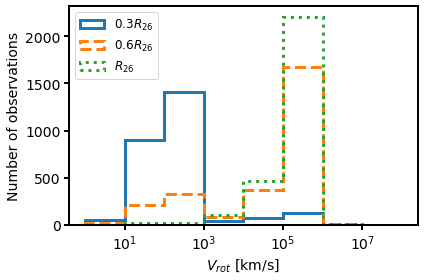

In [23]:
plt.figure(tight_layout=True)

v_bins = np.logspace(0,8, 9)
lwidth = 3
fsize = 14

plt.hist(np.abs(PV_observed['V_ROT'][r0p3]), 
         bins=v_bins, 
         histtype='step', 
         linewidth=lwidth, 
         label='0.3$R_{26}$')

plt.hist(np.abs(PV_observed['V_ROT'][r0p6]), 
         bins=v_bins, 
         histtype='step', 
         linewidth=lwidth, 
         linestyle='--',
         label='0.6$R_{26}$')

plt.hist(np.abs(PV_observed['V_ROT'][r1]), 
         bins=v_bins, 
         histtype='step', 
         linewidth=lwidth, 
         linestyle=':',
         label='$R_{26}$')

plt.xscale('log')
#plt.ylim(ymax=2800)

plt.xlabel('$V_{rot}$ [km/s]', fontsize=fsize)
plt.ylabel('Number of observations', fontsize=fsize)

ax = plt.gca()
ax.tick_params(labelsize=fsize, length=5, width=lwidth-1)
ax.spines['bottom'].set_linewidth(lwidth-1)
ax.spines['left'].set_linewidth(lwidth-1)
ax.spines['right'].set_linewidth(lwidth-1)
ax.spines['top'].set_linewidth(lwidth-1)

plt.legend(loc='upper left', fontsize=fsize-2)

plt.savefig('../images/fuji_Vrot_hist.pdf', dpi=300)

In [28]:
v_max = 1000*u.km/u.s
chi2_max = 25

# 0.3R26
print('0.33 R26 (N =', sum(r0p3), ')')
print('----------------------------------------------------')
print('Fraction of successful redshifts', 
      np.sum(PV_SGA_ztable['V_ROT'][r0p3] < v_max)/np.sum(r0p3))
print('Fraction of failed redshifts', 
      np.sum(PV_SGA_ztable['V_ROT'][r0p3] > v_max)/np.sum(r0p3))
print('Fraction of successful redshifts (DELTACHI2 >', chi2_max, '& ZWARN == 0)', 
      np.sum(np.logical_and(PV_SGA_ztable['DELTACHI2'][r0p3] > chi2_max, 
                            PV_SGA_ztable['ZWARN'][r0p3] == 0))/np.sum(r0p3))
print('Number of observations with "successful" redshifts but fail either DELTACHI2 or ZWARN', 
      np.sum(np.logical_and(PV_SGA_ztable['V_ROT'][r0p3] < v_max, 
                            np.logical_or(PV_SGA_ztable['DELTACHI2'][r0p3] <= chi2_max, 
                                          PV_SGA_ztable['ZWARN'][r0p3] != 0))))
print('Fraction of successful redshifts during bright time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p3, bright)] < v_max)/np.sum(np.logical_and(r0p3, bright)))
print('Fraction of failed redshifts during bright time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p3, bright)] > v_max)/np.sum(np.logical_and(r0p3, bright)))
print('Fraction of successful redshifts during dark time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p3, dark)] < v_max)/np.sum(np.logical_and(r0p3, dark)))
print('Fraction of failed redshifts during dark time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p3, dark)] > v_max)/np.sum(np.logical_and(r0p3, dark)))
print('\n')

# 0.6R26
print('0.66 R26 (N =', sum(r0p6), ')')
print('----------------------------------------------------')
print('Fraction of successful redshifts', 
      np.sum(PV_SGA_ztable['V_ROT'][r0p6] < v_max)/np.sum(r0p6))
print('Fraction of failed redshifts', 
      np.sum(PV_SGA_ztable['V_ROT'][r0p6] > v_max)/np.sum(r0p6))
print('Fraction of successful redshifts (DELTACHI2 >', chi2_max, '& ZWARN == 0)', 
      np.sum(np.logical_and(PV_SGA_ztable['DELTACHI2'][r0p6] > chi2_max, 
                            PV_SGA_ztable['ZWARN'][r0p6] == 0))/np.sum(r0p6))
print('Number of observations with "successful" redshifts but fail either DELTACHI2 or ZWARN', 
      np.sum(np.logical_and(PV_SGA_ztable['V_ROT'][r0p6] < v_max, 
                            np.logical_or(PV_SGA_ztable['DELTACHI2'][r0p6] <= chi2_max, 
                                          PV_SGA_ztable['ZWARN'][r0p6] != 0))))
print('Fraction of successful redshifts during bright time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p6, bright)] < v_max)/np.sum(np.logical_and(r0p6, bright)))
print('Fraction of failed redshifts during bright time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p6, bright)] > v_max)/np.sum(np.logical_and(r0p6, bright)))
print('Fraction of successful redshifts during dark time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p6, dark)] < v_max)/np.sum(np.logical_and(r0p6, dark)))
print('Fraction of failed redshifts during dark time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p6, dark)] > v_max)/np.sum(np.logical_and(r0p6, dark)))
print('\n')

# R26
print('R26 (N =', sum(r1), ')')
print('----------------------------------------------------')
print('Fraction of successful redshifts', 
      np.sum(PV_SGA_ztable['V_ROT'][r1] < v_max)/np.sum(r1))
print('Fraction of failed redshifts', 
      np.sum(PV_SGA_ztable['V_ROT'][r1] > v_max)/np.sum(r1))
print('Fraction of successful redshifts (DELTACHI2 >', chi2_max, '& ZWARN == 0)', 
      np.sum(np.logical_and(PV_SGA_ztable['DELTACHI2'][r1] > chi2_max, 
                            PV_SGA_ztable['ZWARN'][r1] == 0))/np.sum(r1))
print('Number of observations with "successful" redshifts but fail either DELTACHI2 or ZWARN', 
      np.sum(np.logical_and(PV_SGA_ztable['V_ROT'][r1] < v_max, 
                            np.logical_or(PV_SGA_ztable['DELTACHI2'][r1] <= chi2_max, 
                                          PV_SGA_ztable['ZWARN'][r1] != 0))))
print('Fraction of successful redshifts during bright time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r1, bright)] < v_max)/np.sum(np.logical_and(r1, bright)))
print('Fraction of failed redshifts during bright time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r1, bright)] > v_max)/np.sum(np.logical_and(r1, bright)))
print('Fraction of successful redshifts during dark time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r1, dark)] < v_max)/np.sum(np.logical_and(r1, dark)))
print('Fraction of failed redshifts during dark time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r1, dark)] > v_max)/np.sum(np.logical_and(r1, dark)))

0.33 R26 (N = 1080 )
----------------------------------------------------
Fraction of successful redshifts 0.9138888888888889
Fraction of failed redshifts 0.08611111111111111
Fraction of successful redshifts (DELTACHI2 > 25 & ZWARN == 0) 0.8685185185185185
Number of observations with "successful" redshifts but fail either DELTACHI2 or ZWARN 69
Fraction of successful redshifts during bright time 0.8714524207011686
Fraction of failed redshifts during bright time 0.1285475792988314
Fraction of successful redshifts during dark time 0.9666666666666667
Fraction of failed redshifts during dark time 0.03333333333333333


0.66 R26 (N = 1233 )
----------------------------------------------------
Fraction of successful redshifts 0.25060827250608275
Fraction of failed redshifts 0.7493917274939172
Fraction of successful redshifts (DELTACHI2 > 25 & ZWARN == 0) 0.145985401459854
Number of observations with "successful" redshifts but fail either DELTACHI2 or ZWARN 158
Fraction of successful redshifts 

### Is there a correlation between inclination angle and a successful redshift?

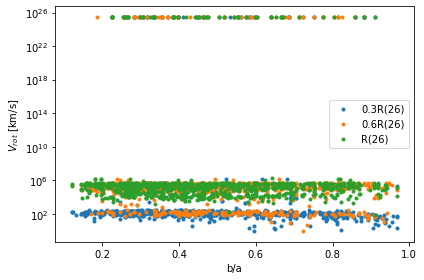

In [50]:
plt.figure()

r0p3 = np.logical_and(PV_SGA_ztable['RADIUS'] > 0.3, PV_SGA_ztable['RADIUS'] < 0.35)
plt.semilogy(SGA['BA'][PV_SGA_ztable['IDX_SGA'][r0p3]], 
             np.abs(PV_SGA_ztable['V_ROT'][r0p3]), '.', label='0.3R(26)')

r0p6 = np.logical_and(PV_SGA_ztable['RADIUS'] > 0.6, PV_SGA_ztable['RADIUS'] < 0.7)
plt.semilogy(SGA['BA'][PV_SGA_ztable['IDX_SGA'][r0p6]], 
             np.abs(PV_SGA_ztable['V_ROT'][r0p6]), '.', label='0.6R(26)')

r1 = PV_SGA_ztable['RADIUS'] > 0.95
plt.semilogy(SGA['BA'][PV_SGA_ztable['IDX_SGA'][r1]], 
             np.abs(PV_SGA_ztable['V_ROT'][r1]), '.', label='R(26)')

plt.xlabel('b/a')
plt.ylabel('$V_{rot}$ [km/s]')

plt.legend()

plt.tight_layout()

# How does $R_{26}$ compare to $0.72R_{23.5}$?

$0.72 R_{23.5}$ is the faintest radius at which David Schlegal determined is the furthest one can go in a galaxy and still detect H$\alpha$.

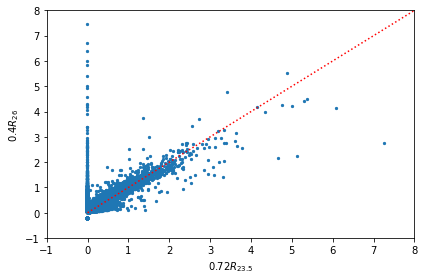

In [69]:
plt.figure()

SGA_23p5 = SGA['RADIUS_SB23.5']*u.arcsec.to(u.arcmin)

plt.scatter(0.72*SGA_23p5.data, 0.4*0.5*SGA['DIAM'].data, s=5)
plt.plot([0,10], [0,10], 'r:')
#plt.hlines()

plt.ylabel('$0.4R_{26}$')
plt.xlabel('$0.72R_{23.5}$')

plt.ylim((-1,8))
plt.xlim((-1,8))

plt.tight_layout()